In [1]:
#!pip install sktime
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

# **Theft Crime**


In [3]:
theft = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_theft_monthly.csv')

## Data Summary

In [4]:
theft.head()

date  primary_type  afternoon  ...  45to54  65to74  75andmore
0  2010-01-31          6038       2244  ...  342384  151070     129473
1  2010-02-28          4781       1889  ...  342384  151070     129473
2  2010-03-31          6049       2283  ...  342384  151070     129473
3  2010-04-30          6102       2237  ...  342384  151070     129473
4  2010-05-31          6684       2466  ...  342384  151070     129473

[5 rows x 204 columns]

In [5]:
# Summary information of data
theft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 204 entries, date to 75andmore
dtypes: float64(2), int64(201), object(1)
memory usage: 240.8+ KB


In [6]:
# Check rows and columns
theft.shape

(151, 204)

In [7]:
theft.describe()

primary_type    afternoon  ...         65to74      75andmore
count    151.000000   151.000000  ...     151.000000     151.000000
mean    4798.688742  1811.807947  ...  173484.443709  134356.185430
std     1818.869752   666.249010  ...   17698.012191    5399.737082
min        0.000000     0.000000  ...  151070.000000  128806.000000
25%     4359.500000  1694.500000  ...  155402.000000  129643.000000
50%     5293.000000  2000.000000  ...  173431.000000  131668.000000
75%     5954.500000  2217.000000  ...  195049.000000  141920.000000
max     7459.000000  2714.000000  ...  195049.000000  141920.000000

[8 rows x 203 columns]

In [8]:
# Check for null values
theft.isnull().sum()

date                                                     0
primary_type                                             0
afternoon                                                0
evening                                                  0
morning                                                  0
night                                                    0
$500 and under                                           0
agg: financial id theft                                  0
attempt financial identity theft                         0
attempt theft                                            0
delivery container theft                                 0
financial id theft: over $300                            0
financial id theft:$300 &under                           0
financial identity theft: over $300                      0
from building                                            0
from coin-op machine/device                              0
from coin-operated machine or device                    

In [9]:
# Change columns to lower string
theft.columns = theft.columns.str.lower()

In [10]:
# Change dtype to datetime
theft['date'] = pd.to_datetime(theft['date'], format='%Y-%m-%d')

In [11]:
# Change dtype to int
for feature in theft.columns:
  if feature == 'avg_temp' or feature == 'unemployment_rate':
    continue
  else:
    if theft[feature].dtype == 'float64':
      theft[feature] = theft[feature].astype('int64')
    else:
      continue

In [12]:
# Removing forecast dates (Only for SARIMXA purposes)
theft = theft[:-12]

In [13]:
# Save checkpoint
theft_ori = theft.copy()

## Understanding Theft Rates

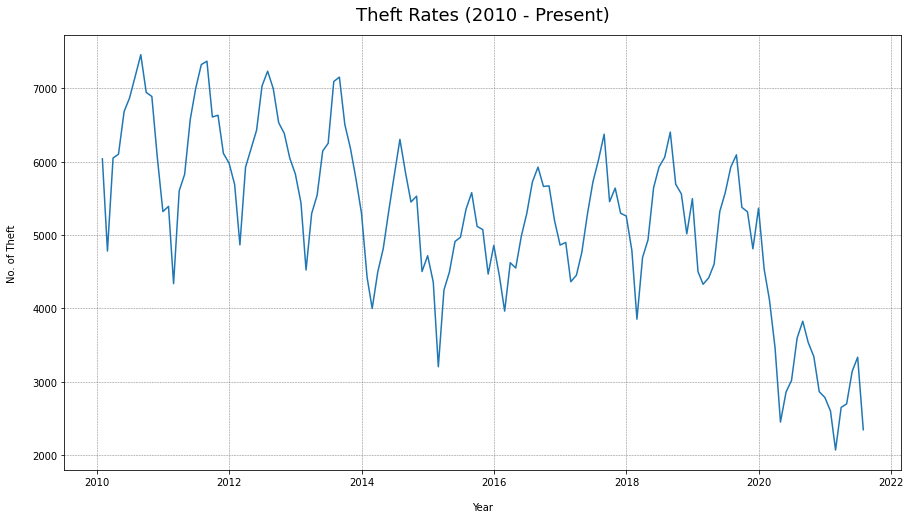

In [14]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')

plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Correlation

In [15]:
# Correlation against 'primary_type' >= 0.5
abs(theft.corr()['primary_type']).sort_values(ascending=False).head(80)

primary_type                              1.000000
afternoon                                 0.984376
morning                                   0.965442
evening                                   0.964225
district_19                               0.939443
night                                     0.937098
district_2                                0.914890
district_8                                0.907429
street                                    0.907127
district_9                                0.901966
district_12                               0.900249
district_22                               0.896810
residential yard (front/back)             0.896200
district_6                                0.893544
residence-garage                          0.888942
other                                     0.886244
district_11                               0.885991
district_10                               0.885443
$500 and under                            0.883939
district_5                     

Text(0.5, 1.0, 'Correlation Heatmap for Battery')

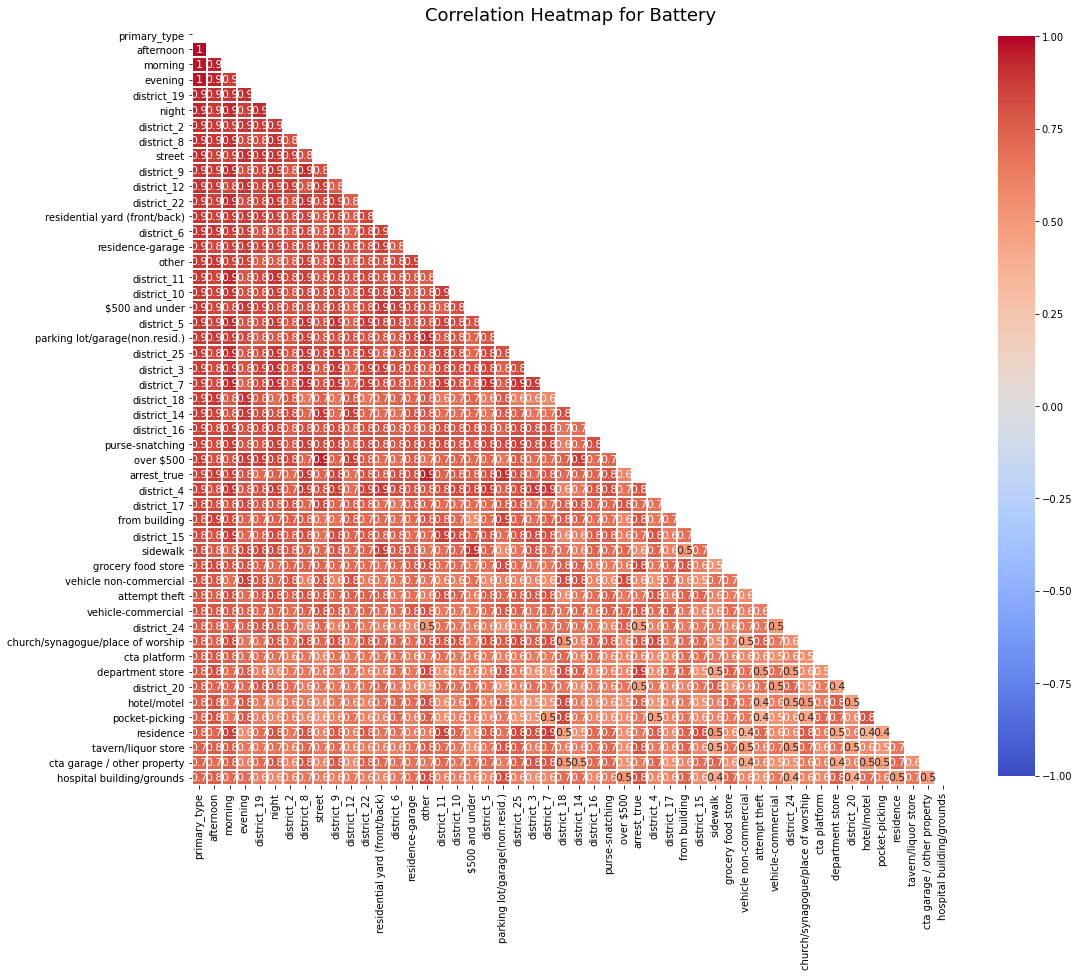

In [16]:
# Plot correlation via heatmap
k = 50
corrmat = theft.corr()
  
cols = corrmat.nlargest(k, 'primary_type')['primary_type'].index
  
cm = np.corrcoef(theft[cols].values.T)
f, ax = plt.subplots(figsize =(17, 17))

mask = np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cm, ax = ax, cmap ="coolwarm", annot=True, linewidths = 0.1, 
            yticklabels = cols.values, xticklabels = cols.values,
            mask=mask, vmin=-1, vmax=1,square=True, linewidth=1, annot_kws={'size':'11'},
            cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

plt.title('Correlation Heatmap for Battery', fontsize=18)


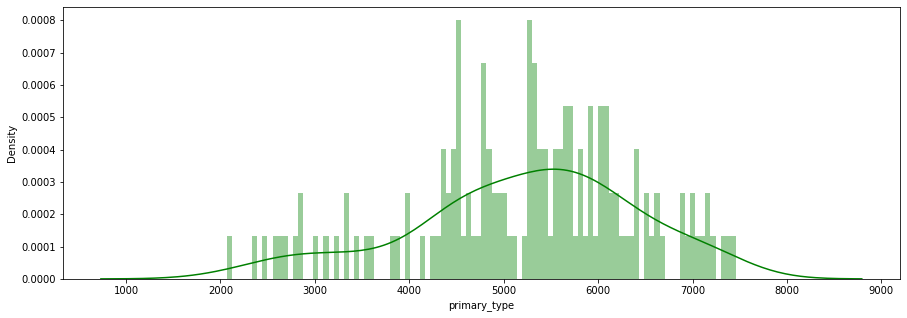

In [17]:
plt.figure(figsize=(15, 5))
sns.distplot(theft['primary_type'], color='g', bins=100, hist_kws={'alpha': 0.4})

### Multicollinearity

In [18]:
# Assigning all other independent features to X variable
X = theft.drop(['primary_type', 'date'], axis=1)

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns 
  
# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

# Print results
vif_data.sort_values(by='VIF', ascending=False).head(20)

feature  VIF
0                                          afternoon  inf
138                         school, public, building  inf
128                                 residence-garage  inf
129                    residential yard (front/back)  inf
130                                       restaurant  inf
131                                 savings and loan  inf
132                        school - private building  inf
133                         school - private grounds  inf
134                         school - public building  inf
135                          school - public grounds  inf
136                        school, private, building  inf
137                         school, private, grounds  inf
139                          school, public, grounds  inf
151  vehicle - commercial: entertainment / party bus  inf
140                                         sidewalk  inf
141                               small retail store  inf
142                           sports arena / stadium  inf
143                             sports arena/stadium  inf
144                                           street  inf
145                            tavern / liquor store  inf

## Data Preparation

In [19]:
# Create train/test splits (using similar Time-Series split)
train_theft = theft[theft['date'] <= '2019-01-01']
test_theft = theft[theft['date'] >= '2018-11-30']

# Create X and y train/test
X_train, y_train = train_theft.drop(['primary_type', 'date'], axis=1), train_theft['primary_type']
X_test, y_test = test_theft.drop(['primary_type', 'date'], axis=1), test_theft['primary_type']

X_train, y_train = train_theft.drop(['primary_type', 'date'], axis=1), train_theft['primary_type']

In [20]:
# Scale data and relabelling as 'Z'
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [21]:
# Checking train test split shape
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (108, 202)
y_train shape is: (108,)
Z_test shape is: (33, 202)
y_test shape is: (33,)


### Principal Component Analysis

In [22]:
# Instantiate PCA
theft_pca = PCA(.95)

# Fit model
theft_pca.fit(Z_train)

PCA(n_components=0.95)

In [23]:
Z_train_pca = theft_pca.transform(Z_train)
Z_test_pca = theft_pca.transform(Z_test)

## **Regression Model**

### Simple Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(Z_train_pca, y_train)

LinearRegression()

In [25]:
# Checking scores between train and test
print (f'Linear training score: {lr.score(Z_train_pca, y_train)}')
print (f'Linear test score: {lr.score(Z_test_pca, y_test)}')

Linear training score: 0.9987437400234846
Linear test score: 0.7221609101645184


In [26]:
# Cross val score for train data
cross = cross_val_score(lr, Z_train_pca, y_train, cv=5).mean()
print (f'CV Training Score: {cross}')

CV Training Score: 0.9531275420950112


In [27]:
lr.coef_

array([-1.18546920e+02,  7.85757149e+01, -4.36423534e+00,  1.37658793e+01,
        7.08982254e+00, -1.20465065e+00, -3.81424659e+00, -5.71100264e+00,
       -8.73944207e+00,  1.12538913e+01,  6.63584794e+00,  8.68219407e+00,
        6.13976904e+00, -2.04243010e+00,  3.87941338e+00,  5.08763937e-01,
        7.53120197e+00, -4.76309316e+00, -8.54255041e+00, -2.71016836e+00,
        7.92423612e+00, -1.28622389e+01, -2.66185028e+00, -5.58394457e+00,
       -3.85643380e+00,  6.76441109e+00,  1.39710970e+01,  3.48150939e+00,
       -1.09737790e+01,  1.60827926e+01, -1.35093897e+00, -1.15518336e+00,
        7.86396590e+00,  3.88619580e+00,  1.58121389e+00,  5.12963911e+00,
        2.33906974e+00,  1.37947804e+00,  6.04918664e+00, -1.31640030e+01,
       -1.18568879e+01,  6.23360319e+00,  6.52091762e+00,  6.48775674e+00,
        7.11157414e+00, -8.88291985e+00, -1.63108587e+00,  7.48893380e+00,
       -6.47854158e+00,  8.04994117e+00,  5.71739281e+00, -1.21534987e+01,
        1.32394048e+01, -

In [28]:
# Finding prediction values
y_preds = lr.predict(Z_test_pca)

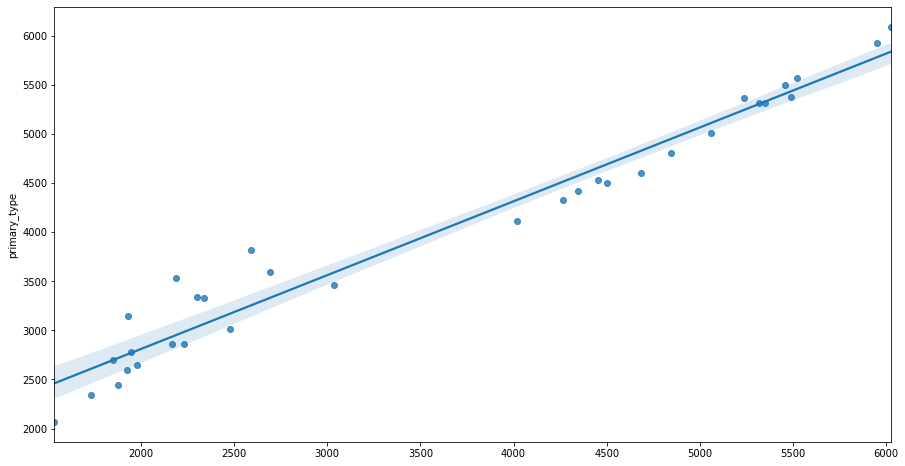

In [29]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds, y_test);

In [30]:
# Evaluation
mse_lr = mean_squared_error(y_test, y_preds)
print (f'MSE Score: {mse_lr}')

rmse_lr = mean_squared_error(y_test, y_preds, squared=False)
print (f'RMSE Score: {rmse_lr}')

mape_lr = mean_absolute_percentage_error(y_test, y_preds)
print (f'MAPE score: {mape_lr}')

MSE Score: 375960.5427780461
RMSE Score: 613.1562140091594
MAPE score: 0.14490604934235116


In [31]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['lr_predictions'] = pd.Series(y_preds)

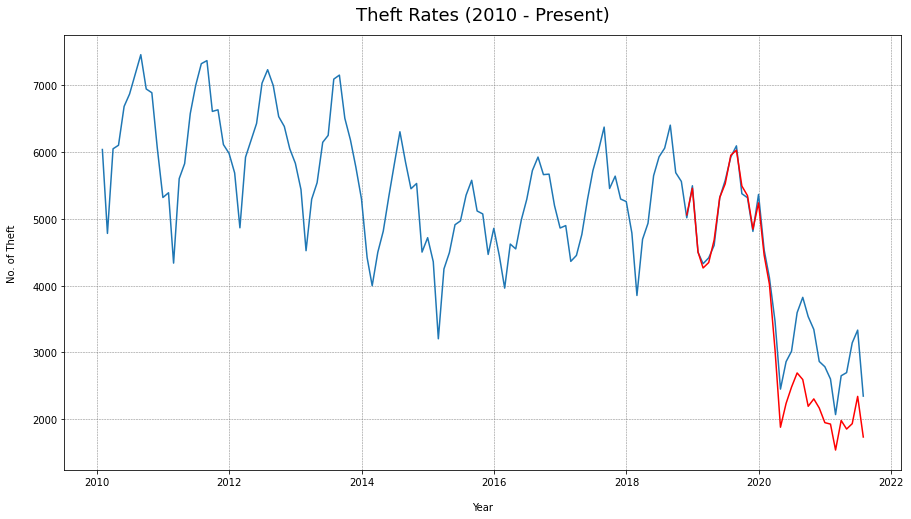

In [32]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='lr_predictions', color='red')

plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Lasso Regression

In [33]:
# Finding best lasso alpha
optimal_lasso = LassoCV(n_alphas=20, cv=5, max_iter=10000)
optimal_lasso.fit(Z_train_pca, y_train)

print (optimal_lasso.alpha_)

5.565236404634783


In [34]:
# Instantiate Lasso regression
lasso = Lasso(alpha=optimal_lasso.alpha_, max_iter=10000)
lasso_scores = cross_val_score(lasso, Z_train_pca, y_train, cv=5)

print (f'Lasso training Cross Val Score: {np.mean(lasso_scores)}')

Lasso training Cross Val Score: 0.9834734952426822


In [35]:
# Fit model
lasso.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Lasso training score: {lasso.score(Z_train_pca, y_train)}')
print (f'Lasso test score: {lasso.score(Z_test_pca, y_test)}')

Lasso training score: 0.9973323517962818
Lasso test score: 0.42574783205556643


In [36]:
lasso.coef_

array([-118.42837318,   78.31033771,   -3.61261632,   12.71042488,
          5.73958281,   -0.        ,   -2.11269582,   -3.91778033,
         -6.72129757,    9.19099931,    4.45327888,    6.44294729,
          3.87327531,   -0.        ,    1.45475906,    0.        ,
          4.90341769,   -2.10898424,   -5.7808603 ,   -0.        ,
          5.02908996,   -9.86902288,   -0.        ,   -2.43193963,
         -0.51195137,    3.25625716,   10.41052507,    0.        ,
         -7.26294161,   12.16316005,   -0.        ,   -0.        ,
          3.6438729 ,    0.        ,    0.        ,    0.35097533,
          0.        ,    0.        ,    0.8697568 ,   -7.83847626,
         -6.29888615,    0.40968613,    0.62974103,    0.35924051,
          0.75312014,   -2.2834893 ,   -0.        ,    0.42875216,
         -0.        ,    0.32696276,    0.        ,   -3.95097529,
          4.58467147,   -0.        ,    1.99575448,    0.        ,
         -1.31930796,    0.        ,   -0.        ,   -0.     

In [37]:
# Finding lasso predictions
y_preds_l = lasso.predict(Z_test_pca)

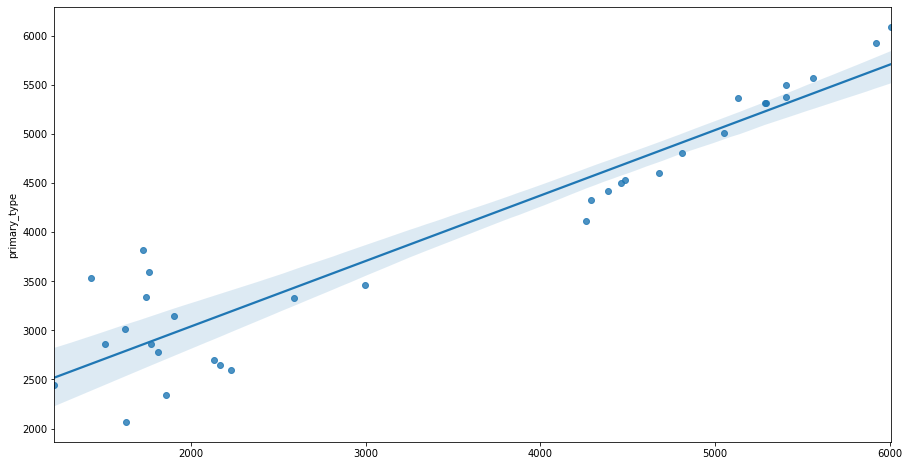

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_l, y_test);

In [39]:
# Evaluation
mse_lasso = mean_squared_error(y_test, y_preds_l)
print (f'MSE Score: {mse_lasso}')

rmse_lasso = mean_squared_error(y_test, y_preds_l, squared=False)
print (f'RMSE Score: {rmse_lasso}')

mape_lasso = mean_absolute_percentage_error(y_test, y_preds_l)
print (f'MAPE score: {mape_lasso}')

MSE Score: 777054.6501563144
RMSE Score: 881.5070335262869
MAPE score: 0.18743823568900714


In [40]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['lasso_predictions'] = pd.Series(y_preds_l)

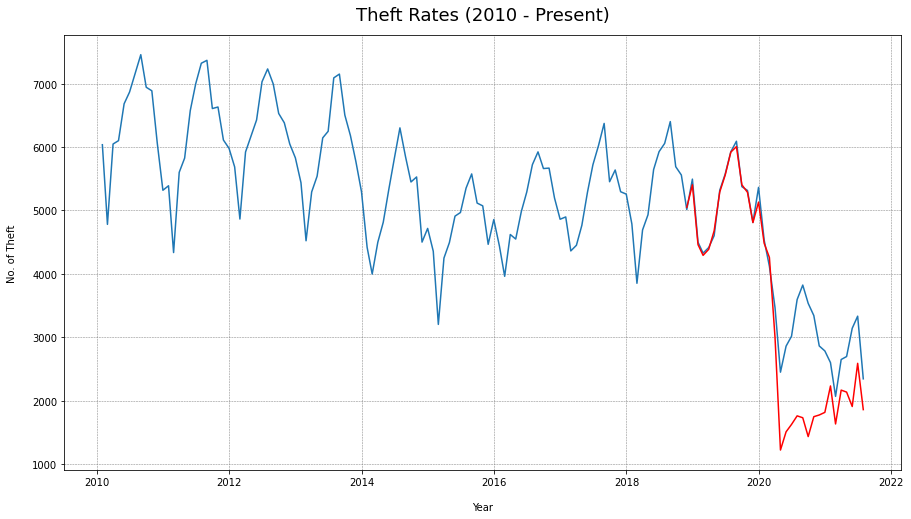

In [41]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='lasso_predictions', color='red')

plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Ridge Regression

In [42]:
# Finding best ridge alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(Z_train_pca, y_train)

print (optimal_ridge.alpha_)

13.509935211980272


In [43]:
# Instantiate ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Z_train_pca, y_train, cv=5)

print (f'Ridge training Cross Val Score: {np.mean(ridge_scores)}')

Ridge training Cross Val Score: 0.986994603007745


In [44]:
# Fit model
ridge.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Ridge training score: {ridge.score(Z_train_pca, y_train)}')
print (f'Ridge test score: {ridge.score(Z_test_pca, y_test)}')

Ridge training score: 0.9986865007625344
Ridge test score: 0.5643692941243574


In [45]:
ridge.coef_

array([-1.18231876e+02,  7.81097910e+01, -4.29172900e+00,  1.34468677e+01,
        6.88098555e+00, -1.16392703e+00, -3.67373921e+00, -5.48972838e+00,
       -8.36020141e+00,  1.07551900e+01,  6.32552733e+00,  8.26613924e+00,
        5.84214191e+00, -1.93991393e+00,  3.67891298e+00,  4.81087640e-01,
        7.11117519e+00, -4.49493673e+00, -8.04326030e+00, -2.54768221e+00,
        7.44007103e+00, -1.20514229e+01, -2.49044806e+00, -5.21450305e+00,
       -3.58679559e+00,  6.26999591e+00,  1.29358133e+01,  3.22020174e+00,
       -1.01289259e+01,  1.47805777e+01, -1.23894179e+00, -1.05570697e+00,
        7.18264413e+00,  3.53047970e+00,  1.43324702e+00,  4.63209682e+00,
        2.11175559e+00,  1.24102475e+00,  5.41837863e+00, -1.17566818e+01,
       -1.05401176e+01,  5.51204137e+00,  5.75840019e+00,  5.70225386e+00,
        6.22227723e+00, -7.73545769e+00, -1.41390207e+00,  6.46325158e+00,
       -5.54345465e+00,  6.85923081e+00,  4.86124800e+00, -1.02615611e+01,
        1.10833049e+01, -

In [46]:
# Finding ridge predictions
y_preds_r = ridge.predict(Z_test_pca)

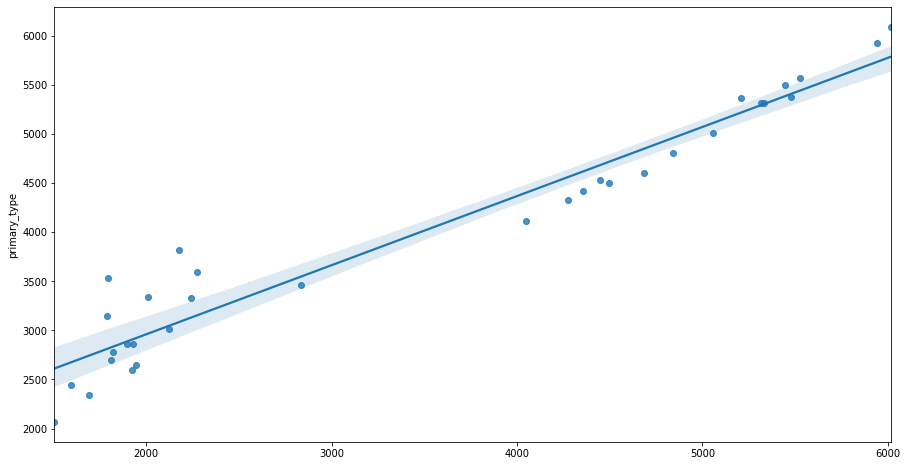

In [47]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_r, y_test);

In [48]:
# Evaluation
mse_ridge = mean_squared_error(y_test, y_preds_r)
print (f'MSE Score: {mse_ridge}')

rmse_ridge = mean_squared_error(y_test, y_preds_r, squared=False)
print (f'RMSE Score: {rmse_ridge}')

mape_ridge = mean_absolute_percentage_error(y_test, y_preds_r)
print (f'MAPE score: {mape_ridge}')

MSE Score: 589477.7323405786
RMSE Score: 767.7745322297286
MAPE score: 0.17765112619245385


In [49]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['ridge_predictions'] = pd.Series(y_preds_r)

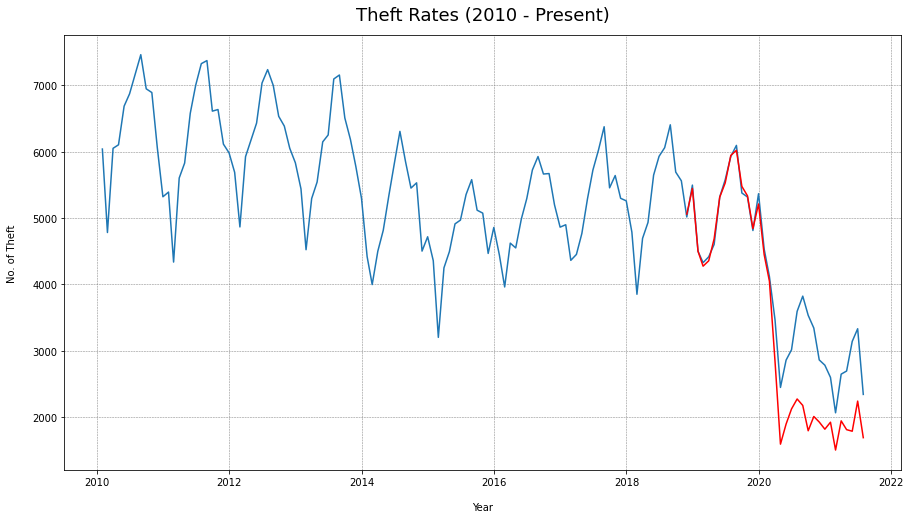

In [50]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='ridge_predictions', color='red')

plt.title('Theft Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

## **Ensemble Methods**

### Random Forest

In [51]:
# Instantiate Random Forest Regression
rf = RandomForestRegressor()

# Fit model
rf.fit(Z_train, y_train)

RandomForestRegressor()

In [52]:
# Scores for train and test data
print (f'Random Forest training score: {rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {rf.score(Z_test, y_test)}')

Random Forest training score: 0.9954473456121624
Random Forest test score: 0.658796160655237


In [53]:
rf_scores = cross_val_score(rf, Z_train, y_train, cv=5)

print (f'Random Forest training Cross Val Score: {np.mean(rf_scores)}')

Random Forest training Cross Val Score: 0.931203628485914


In [54]:
# Finding lasso predictions
y_preds_rf = rf.predict(Z_test)

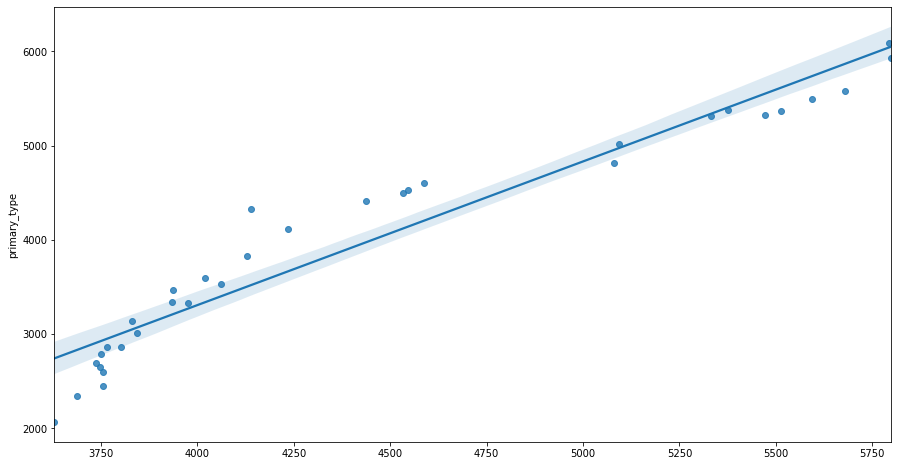

In [55]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf, y_test);

In [56]:
# Evaluation
mse_rf = mean_squared_error(y_test, y_preds_rf)
print (f'MSE Score: {mse_rf}')

rmse_rf = mean_squared_error(y_test, y_preds_rf, squared=False)
print (f'RMSE Score: {rmse_rf}')

mape_rf = mean_absolute_percentage_error(y_test, y_preds_rf)
print (f'MAPE score: {mape_rf}')

MSE Score: 461703.1416060606
RMSE Score: 679.4874109253685
MAPE score: 0.17520590576410408


In [57]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['rf_predictions'] = pd.Series(y_preds_rf)

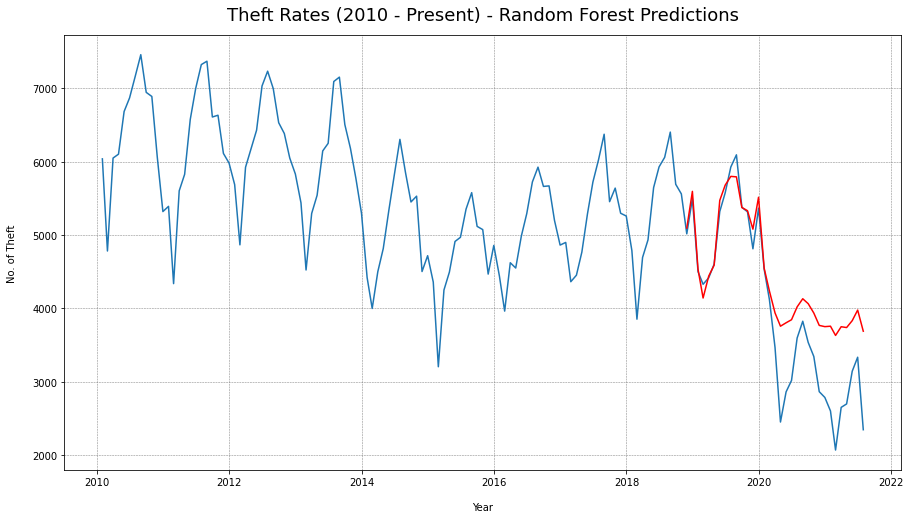

In [58]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='rf_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

 **Gridsearch**

In [59]:
# Instantiate Random Forest Regression
rf1 = RandomForestRegressor()

# Assign hyperparameters
rf_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [60]:
# Instatntiate GridsearchCV
gs_rf = GridSearchCV(rf1, param_grid=rf_params, cv=5, verbose=2)

# Fit model
gs_rf.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_rf.best_score_}')
print(f'Best parameters: {gs_rf.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=150; total time=   0.6s
[CV] END ...............min_samples_leaf=1, n_e

In [61]:
# Scores for train and test data
print (f'Random Forest training score: {gs_rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {gs_rf.score(Z_test, y_test)}')

Random Forest training score: 0.9953728818061155
Random Forest test score: 0.689200159204207


In [62]:
y_preds_rf2 = gs_rf.predict(Z_test)

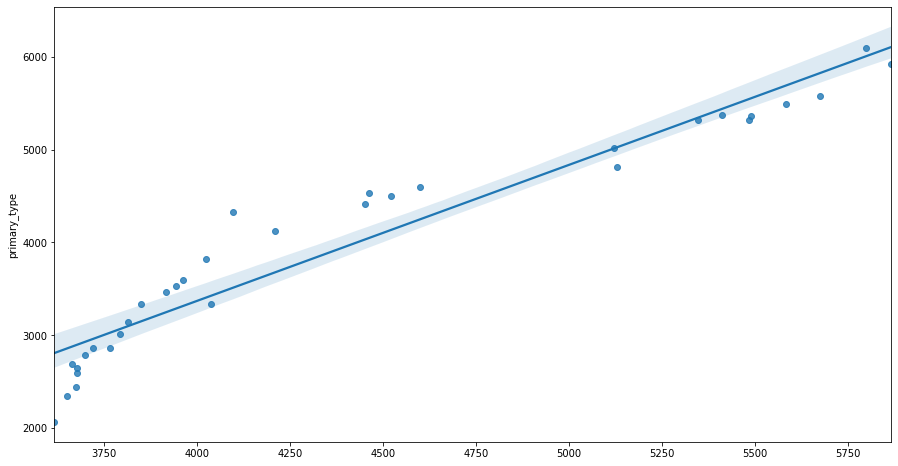

In [63]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf2, y_test);

In [64]:
# Evaluation
mse_rf2 = mean_squared_error(y_test, y_preds_rf2)
print (f'MSE Score: {mse_rf2}')

rmse_rf2 = mean_squared_error(y_test, y_preds_rf2, squared=False)
print (f'RMSE Score: {rmse_rf2}')

mape_rf2 = mean_absolute_percentage_error(y_test, y_preds_rf2)
print (f'MAPE score: {mape_rf2}')

MSE Score: 420561.68881818186
RMSE Score: 648.5072773825918
MAPE score: 0.16693652392683683


In [65]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['rf2_predictions'] = pd.Series(y_preds_rf2)

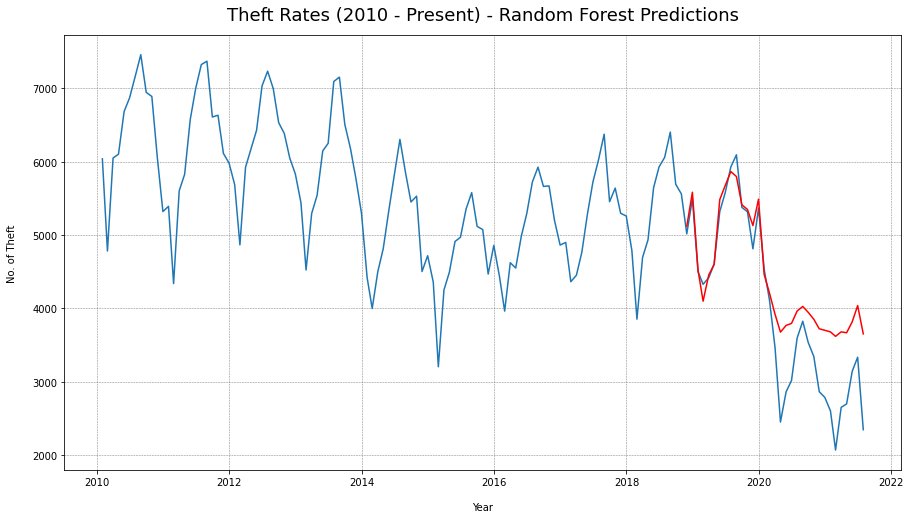

In [66]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='rf2_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Gradient Boost

In [67]:
# Instantiate Random Forest Regression
gb = GradientBoostingRegressor()

# Fit model
gb.fit(Z_train, y_train)

GradientBoostingRegressor()

In [68]:
# Scores for train and test data
print (f'Gradient Boosting training score: {gb.score(Z_train, y_train)}')
print (f'Gradient Boosting test score: {gb.score(Z_test, y_test)}')

Gradient Boosting training score: 0.9999903539959739
Gradient Boosting test score: 0.7521430163653984


In [69]:
gb_scores = cross_val_score(gb, Z_train, y_train, cv=5)

print (f'Gradient Boosting training Cross Val Score: {np.mean(gb_scores)}')

Gradient Boosting training Cross Val Score: 0.9421230699412098


In [70]:
# Finding lasso predictions
y_preds_gb = gb.predict(Z_test)

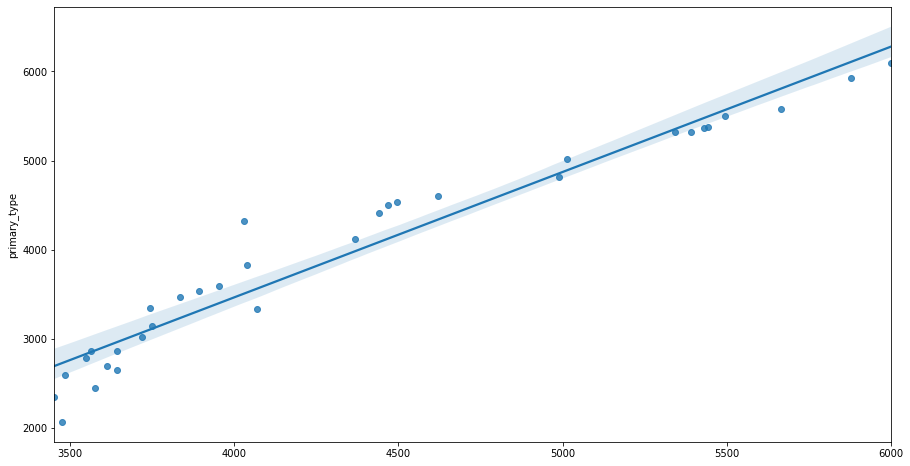

In [71]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb, y_test);

In [72]:
# Evaluation
mse_gb = mean_squared_error(y_test, y_preds_gb)
print (f'MSE Score: {mse_gb}')

rmse_gb = mean_squared_error(y_test, y_preds_gb, squared=False)
print (f'RMSE Score: {rmse_gb}')

mape_gb = mean_absolute_percentage_error(y_test, y_preds_gb)
print (f'MAPE score: {mape_gb}')

MSE Score: 335389.9775361774
RMSE Score: 579.1286364325092
MAPE score: 0.14802176939789116


In [73]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['gb_predictions'] = pd.Series(y_preds_gb)

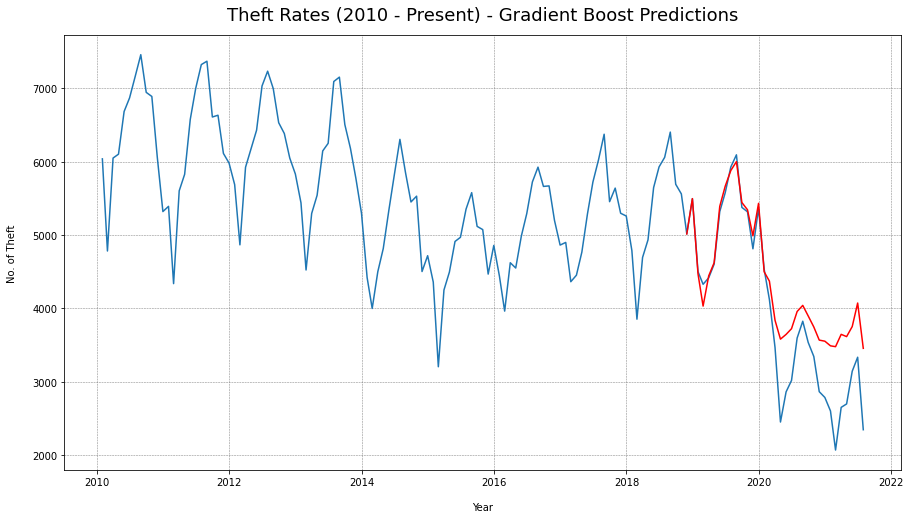

In [74]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='gb_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [75]:
# Instantiate Random Forest Regression
gb1 = GradientBoostingRegressor()

# Assign hyperparameters
gb_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'learning_rate': [.05, .1, .15, .2, .3]
}

In [76]:
# Instatntiate GridsearchCV
gs_gb = GridSearchCV(gb1, param_grid=gb_params, cv=5, verbose=2)

# Fit model
gs_gb.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_gb.best_score_}')
print(f'Best parameters: {gs_gb.best_params_}')

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=150; total time

In [77]:
# Scores for train and test data
print (f'Gradient Boost training score: {gs_gb.score(Z_train, y_train)}')
print (f'Gradient Boost test score: {gs_gb.score(Z_test, y_test)}')

Gradient Boost training score: 0.9999999316063087
Gradient Boost test score: 0.8474244003897872


In [78]:
y_preds_gb2 = gs_gb.predict(Z_test)

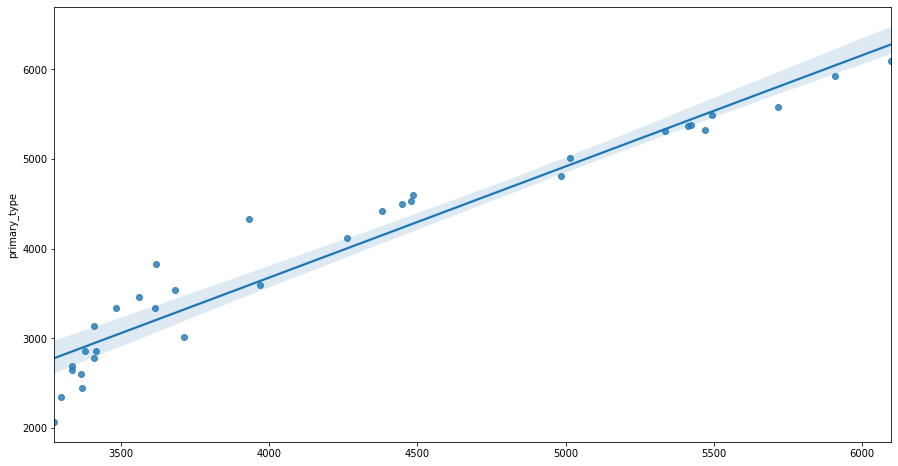

In [79]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb2, y_test);

In [80]:
# Evaluation
mse_gb2 = mean_squared_error(y_test, y_preds_gb2)
print (f'MSE Score: {mse_gb2}')

rmse_gb2 = mean_squared_error(y_test, y_preds_gb2, squared=False)
print (f'RMSE Score: {rmse_gb2}')

mape_gb2 = mean_absolute_percentage_error(y_test, y_preds_gb2)
print (f'MAPE score: {mape_gb2}')

MSE Score: 206459.0885253323
RMSE Score: 454.3776936925187
MAPE score: 0.11309535046946674


In [81]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['gb2_predictions'] = pd.Series(y_preds_gb2)

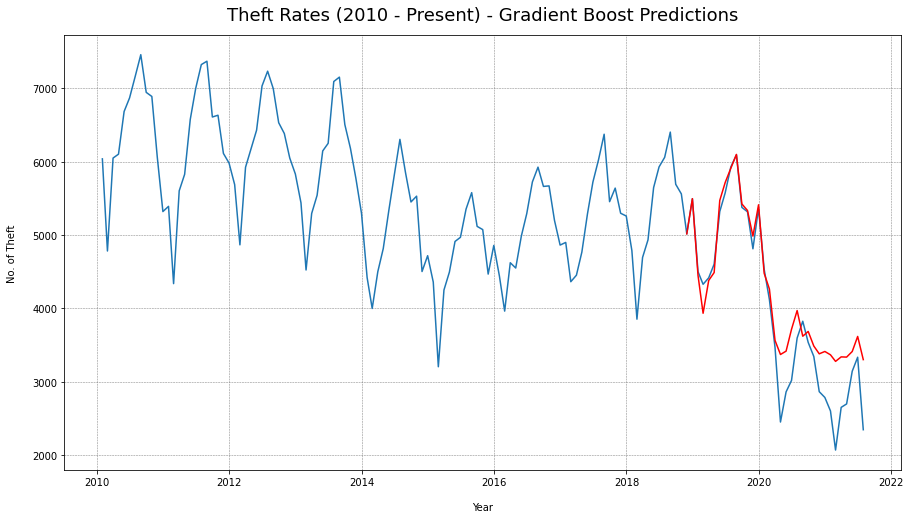

In [82]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='gb2_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ADA Boost



In [83]:
# Instantiate Random Forest Regression
ab = AdaBoostRegressor()

# Fit model
ab.fit(Z_train, y_train)

AdaBoostRegressor()

In [84]:
# Scores for train and test data
print (f'ADA Boosting training score: {ab.score(Z_train, y_train)}')
print (f'ADA Boosting test score: {ab.score(Z_test, y_test)}')

ADA Boosting training score: 0.9905964171631509
ADA Boosting test score: 0.6000847199313253


In [85]:
ab_scores = cross_val_score(ab, Z_train, y_train, cv=5)

print (f'ADA Boosting training Cross Val Score: {np.mean(ab_scores)}')

ADA Boosting training Cross Val Score: 0.9047979347990127


In [86]:
# Finding lasso predictions
y_preds_ab = ab.predict(Z_test)

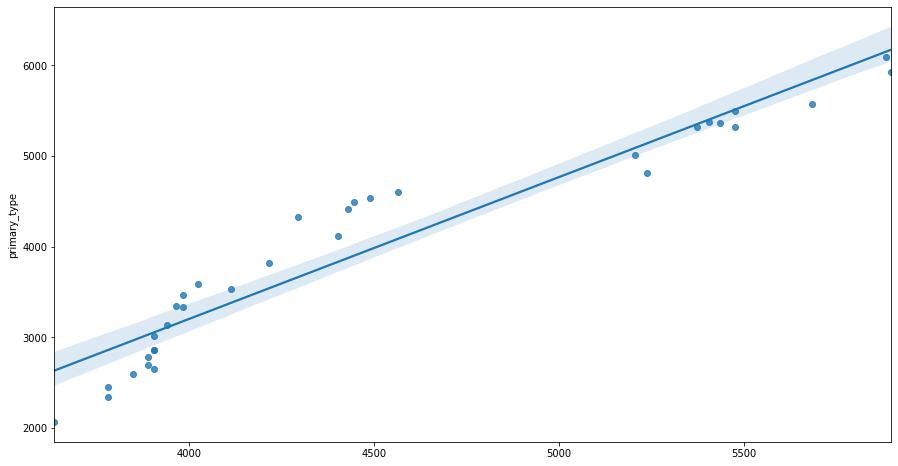

In [87]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab, y_test);

In [88]:
# Evaluation
mse_ab = mean_squared_error(y_test, y_preds_ab)
print (f'MSE Score: {mse_ab}')

rmse_ab = mean_squared_error(y_test, y_preds_ab, squared=False)
print (f'RMSE Score: {rmse_ab}')

mape_ab = mean_absolute_percentage_error(y_test, y_preds_ab)
print (f'MAPE score: {mape_ab}')

MSE Score: 541149.0724681048
RMSE Score: 735.6283521372085
MAPE score: 0.1899378525884177


In [89]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['ab_predictions'] = pd.Series(y_preds_ab)

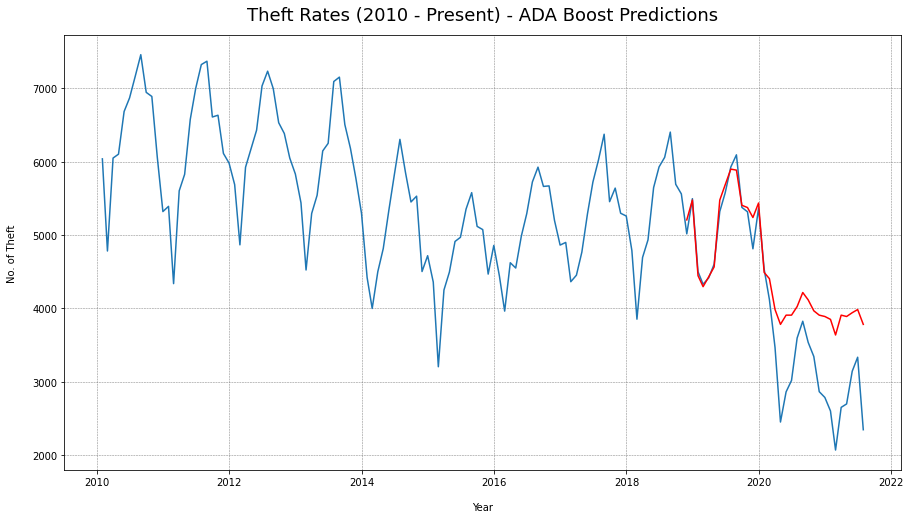

In [90]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='ab_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [91]:
# Instantiate Random Forest Regression
ab1 = AdaBoostRegressor()

# Assign hyperparameters
ab_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3],
}

In [92]:
# Instatntiate GridsearchCV
gs_ab = GridSearchCV(ab1, param_grid=ab_params, cv=5, verbose=2)

# Fit model
gs_ab.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_ab.best_score_}')
print(f'Best parameters: {gs_ab.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=150; total time=   0.5s
[CV] END ...............learning_rate=0.05, n_e

In [93]:
# Scores for train and test data
print (f'Adaptive Boost training score: {gs_ab.score(Z_train, y_train)}')
print (f'Adaptive Boost test score: {gs_ab.score(Z_test, y_test)}')

Adaptive Boost training score: 0.9901503792371322
Adaptive Boost test score: 0.6209767950699303


In [94]:
y_preds_ab2 = gs_ab.predict(Z_test)

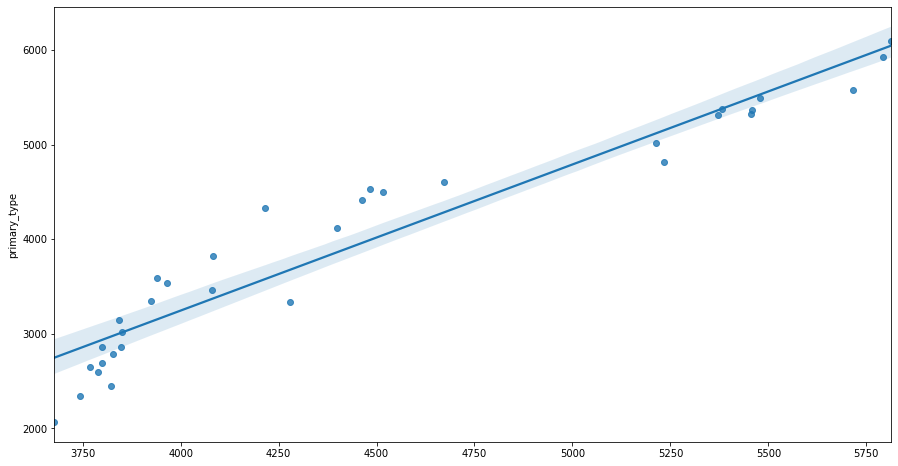

In [95]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab2, y_test);

In [96]:
# Evaluation
mse_ab2 = mean_squared_error(y_test, y_preds_ab2)
print (f'MSE Score: {mse_ab2}')

rmse_ab2 = mean_squared_error(y_test, y_preds_ab2, squared=False)
print (f'RMSE Score: {rmse_ab2}')

mape_ab2 = mean_absolute_percentage_error(y_test, y_preds_ab2)
print (f'MAPE score: {mape_ab2}')

MSE Score: 512878.7671143093
RMSE Score: 716.1555467315109
MAPE score: 0.18526950689404337


In [97]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['ab2_predictions'] = pd.Series(y_preds_ab2)

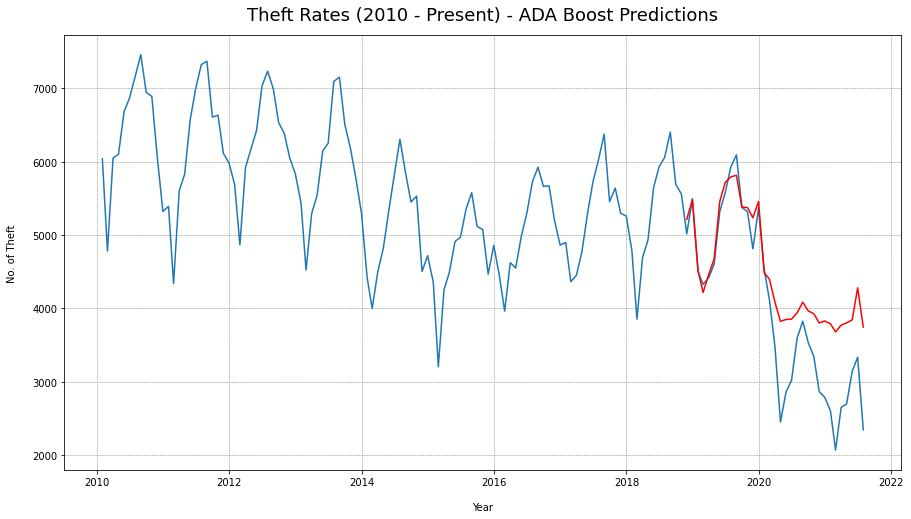

In [98]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='ab2_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### XGBoost

In [99]:
# Instantiate Random Forest Regression
xg = XGBRegressor()

# Fit model
xg.fit(Z_train, y_train)

[06:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [100]:
# Scores for train and test data
print (f'XG Boosting training score: {xg.score(Z_train, y_train)}')
print (f'XG Boosting test score: {xg.score(Z_test, y_test)}')

XG Boosting training score: 0.9998932661747731
XG Boosting test score: 0.88753577824684


In [101]:
xg_scores = cross_val_score(xg, Z_train, y_train, cv=5)

print (f'XG Boosting training Cross Val Score: {np.mean(xg_scores)}')

[06:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boosting training Cross Val Score: 0.9528361877203428


In [102]:
# Finding lasso predictions
y_preds_xg = xg.predict(Z_test)

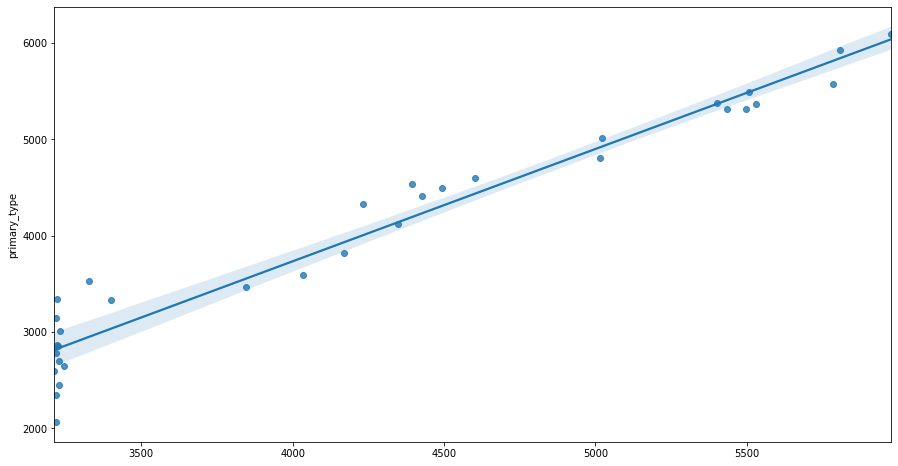

In [103]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg, y_test);

In [104]:
# Evaluation
mse_xg = mean_squared_error(y_test, y_preds_xg)
print (f'MSE Score: {mse_xg}')

rmse_xg = mean_squared_error(y_test, y_preds_xg, squared=False)
print (f'RMSE Score: {rmse_xg}')

mape_xg = mean_absolute_percentage_error(y_test, y_preds_xg)
print (f'MAPE score: {mape_xg}')

MSE Score: 152182.00534152804
RMSE Score: 390.1051208860607
MAPE score: 0.09646002474223672


In [105]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['xg_predictions'] = pd.Series(y_preds_xg)

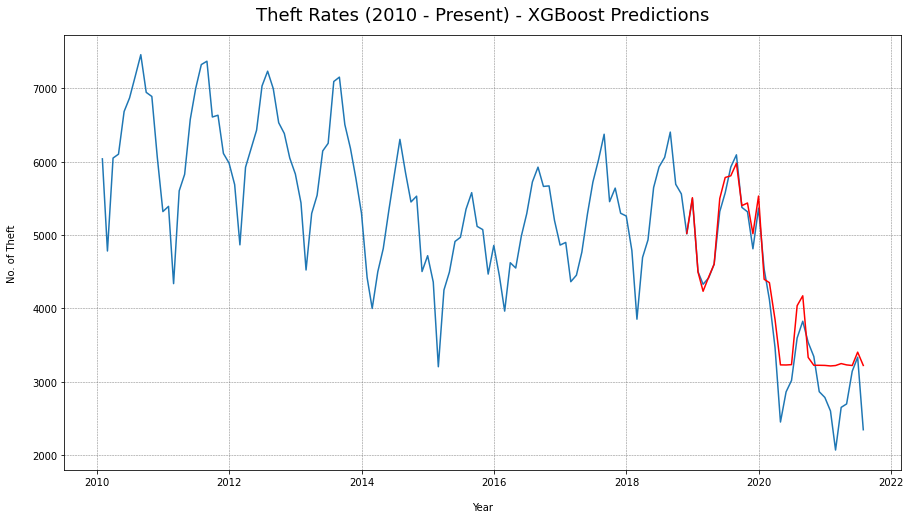

In [106]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='xg_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [107]:
# Instantiate Random Forest Regression
xg1 = XGBRegressor()

# Assign hyperparameters
xg_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3],
    'lambda': [1, 2, 3]
}

In [108]:
# Instatntiate GridsearchCV
gs_xg = GridSearchCV(xg1, param_grid=xg_params, cv=5, verbose=2)

# Fit model
gs_xg.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_xg.best_score_}')
print(f'Best parameters: {gs_xg.best_params_}')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[06:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:15:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:15:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:15:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

In [109]:
# Scores for train and test data
print (f'Adaptive Boost training score: {gs_xg.score(Z_train, y_train)}')
print (f'Adaptive Boost test score: {gs_xg.score(Z_test, y_test)}')

Adaptive Boost training score: 0.9999205797330716
Adaptive Boost test score: 0.8905198566777563


In [110]:
y_preds_xg2 = gs_xg.predict(Z_test)

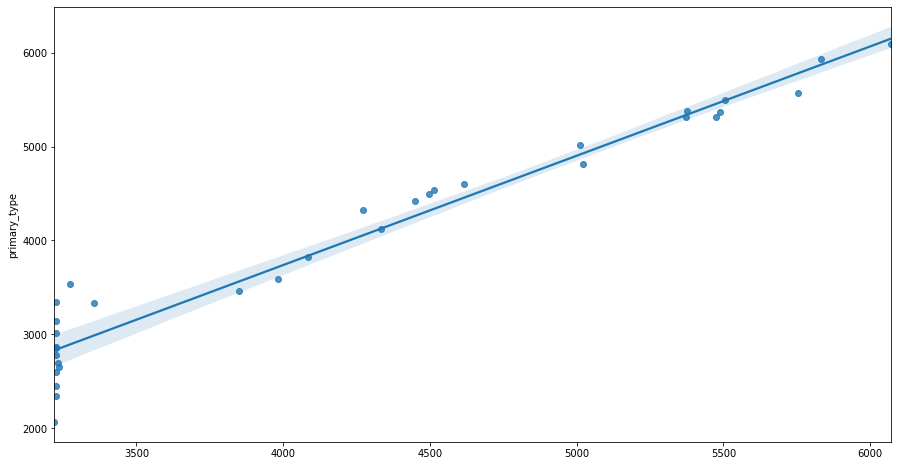

In [111]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg2, y_test);

In [112]:
# Evaluation
mse_xg2 = mean_squared_error(y_test, y_preds_xg2)
print (f'MSE Score: {mse_xg2}')

rmse_xg2 = mean_squared_error(y_test, y_preds_xg2, squared=False)
print (f'RMSE Score: {rmse_xg2}')

mape_xg2 = mean_absolute_percentage_error(y_test, y_preds_xg2)
print (f'MAPE score: {mape_xg2}')

MSE Score: 148144.07192026667
RMSE Score: 384.89488424798094
MAPE score: 0.09312016710289492


In [113]:
test_theft = test_theft.reset_index().drop('index', axis=1)
test_theft['ab2_predictions'] = pd.Series(y_preds_ab2)

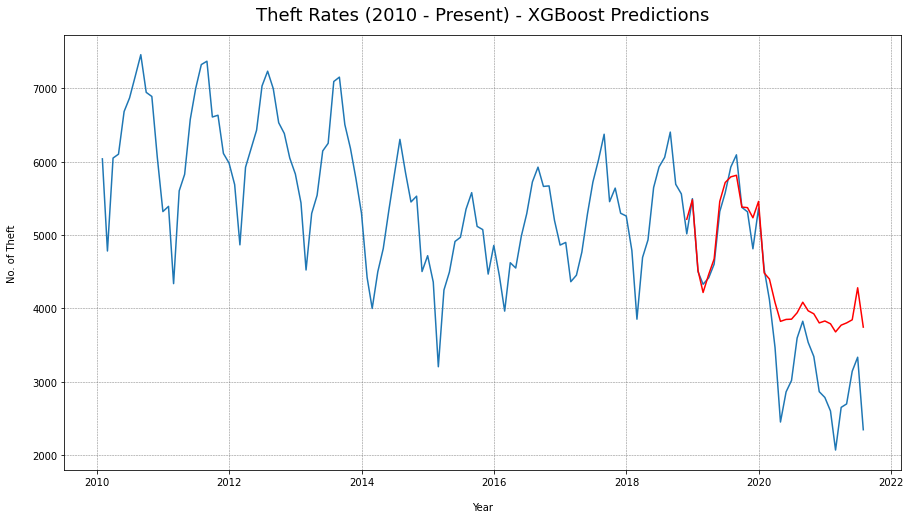

In [114]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=theft, x='date', y='primary_type')
sns.lineplot(data=test_theft, x='date', y='ab2_predictions', color='red')

plt.title('Theft Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ***Based on regression model:***

|Model|RMSE|MAE|
|---|---|---|
|Linear Regression|613.1562140091336|0.14490604934234505|
|Lasso Regression|881.5070335262901|0.18743823568900794|
|Ridge Regression|767.7745322297379|0.17765112619245602|
|Random Forest|741.1621040228285|0.19213150641561164|
|Gradient Boost|433.44800404625664|0.1075472707600234|
|Adaptive Boost|635.0832820427898|0.1650061963983871|
|XG Boost|384.89488424798094|0.09312016710289492|

## **Evaluation**
- XG Boost is better comparing to other models with an error % below 10%

# **Battery Crime**


In [115]:
battery = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_battery_monthly.csv')

## Data Summary

In [116]:
battery.head()

date  primary_type  afternoon  ...  45to54  65to74  75andmore
0  2010-01-31          4653       1471  ...  342384  151070     129473
1  2010-02-28          4241       1379  ...  342384  151070     129473
2  2010-03-31          6021       1894  ...  342384  151070     129473
3  2010-04-30          5857       1826  ...  342384  151070     129473
4  2010-05-31          6396       1904  ...  342384  151070     129473

[5 rows x 234 columns]

In [117]:
# Summary information of data
battery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 234 entries, date to 75andmore
dtypes: float64(2), int64(231), object(1)
memory usage: 276.2+ KB


In [118]:
# Check rows and columns
battery.shape

(151, 234)

In [119]:
battery.describe()

primary_type    afternoon  ...         65to74      75andmore
count    151.000000   151.000000  ...     151.000000     151.000000
mean    3957.880795  1131.258278  ...  173484.443709  134356.185430
std     1413.810246   399.270609  ...   17698.012191    5399.737082
min        0.000000     0.000000  ...  151070.000000  128806.000000
25%     3568.000000  1033.000000  ...  155402.000000  129643.000000
50%     4144.000000  1200.000000  ...  173431.000000  131668.000000
75%     4716.500000  1325.500000  ...  195049.000000  141920.000000
max     6396.000000  1904.000000  ...  195049.000000  141920.000000

[8 rows x 233 columns]

In [120]:
# Check for null values
battery.isnull().sum()

date                                                            0
primary_type                                                    0
afternoon                                                       0
evening                                                         0
morning                                                         0
night                                                           0
agg po hands etc serious inj                                    0
agg po hands no/min injury                                      0
agg pro emp hands serious inj                                   0
agg pro.emp: handgun                                            0
agg pro.emp: other dang weapon                                  0
agg pro.emp: other firearm                                      0
agg pro.emp:knife/cutting inst                                  0
agg. domestic battery - hands, fists, feet, serious injury      0
agg. protected employee - hands, fists, feet, serious injury    0
agg: hands

In [121]:
# Change columns to lower string
battery.columns = battery.columns.str.lower()

In [122]:
# Change dtype to datetime
battery['date'] = pd.to_datetime(battery['date'], format='%Y-%m-%d')

In [123]:
# Change dtype to int
for feature in battery.columns:
  if feature == 'avg_temp' or feature == 'unemployment_rate':
    continue
  else:
    if battery[feature].dtype == 'float64':
      battery[feature] = battery[feature].astype('int64')
    else:
      continue

In [124]:
# Removing forecast dates (Only for SARIMXA purposes)
battery = battery[:-12]

In [125]:
# Save checkpoint
battery_ori = battery.copy()

## Understanding Battery Rates

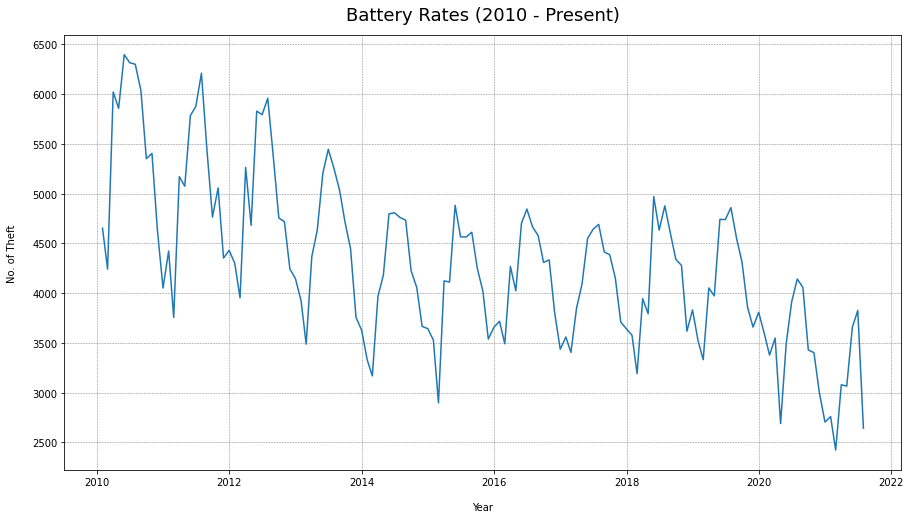

In [126]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')

plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Correlation

In [127]:
# Correlation against 'primary_type' >= 0.5
abs(battery.corr()['primary_type']).sort_values(ascending=False).head(80)

primary_type                                                  1.000000
domestic battery simple                                       0.991993
evening                                                       0.972031
domestic_true                                                 0.965963
district_7                                                    0.957201
district_8                                                    0.953057
sidewalk                                                      0.948144
district_25                                                   0.939074
district_4                                                    0.938696
district_3                                                    0.936328
district_9                                                    0.935988
district_5                                                    0.935607
night                                                         0.931595
district_11                                                   0.925006
street

Text(0.5, 1.0, 'Correlation Heatmap for Battery')

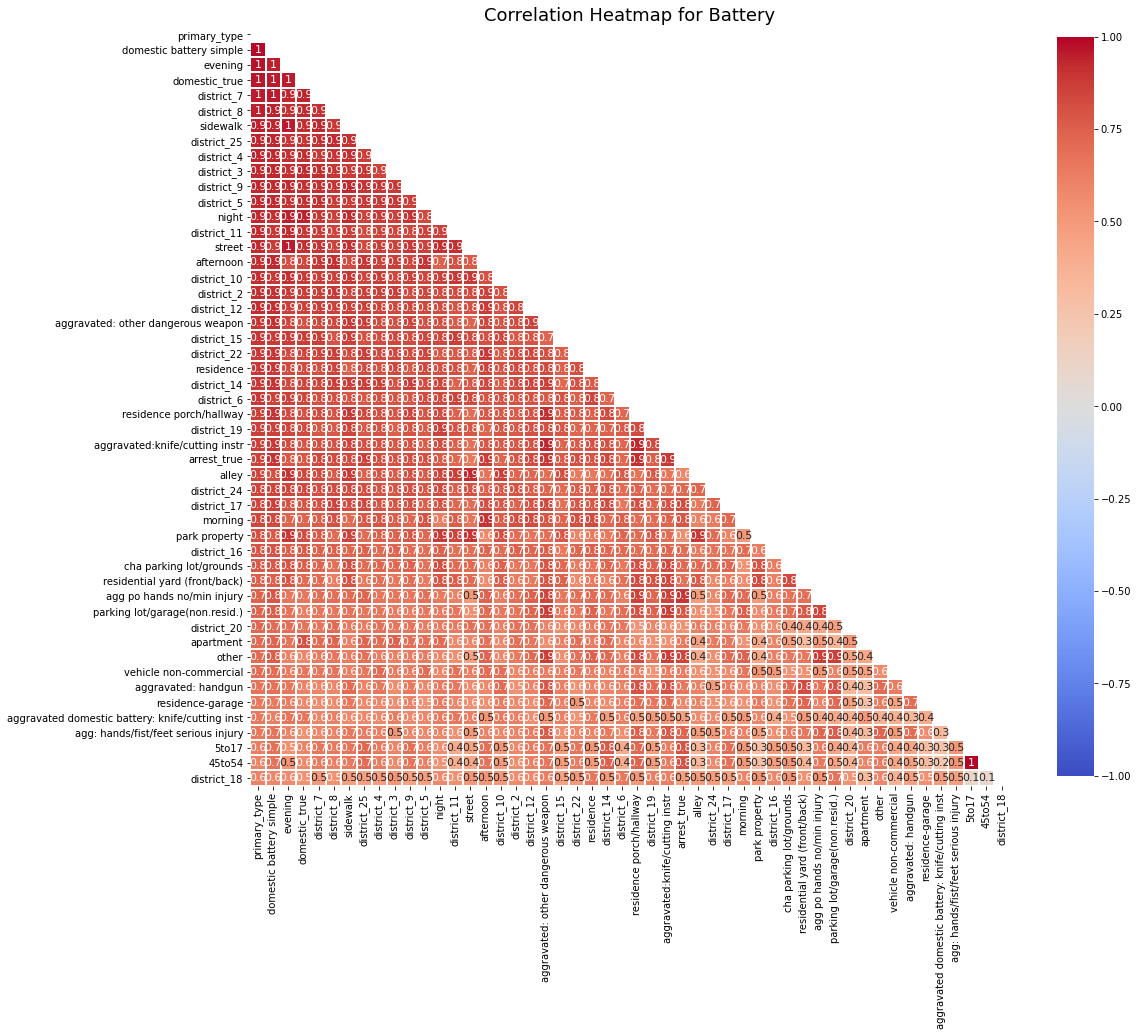

In [128]:
# Plot correlation via heatmap
k = 50
corrmat = battery.corr()
  
cols = corrmat.nlargest(k, 'primary_type')['primary_type'].index
  
cm = np.corrcoef(battery[cols].values.T)
f, ax = plt.subplots(figsize =(17, 17))

mask = np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cm, ax = ax, cmap ="coolwarm", annot=True, linewidths = 0.1, 
            yticklabels = cols.values, xticklabels = cols.values,
            mask=mask, vmin=-1, vmax=1,square=True, linewidth=1, annot_kws={'size':'11'},
            cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

plt.title('Correlation Heatmap for Battery', fontsize=18)

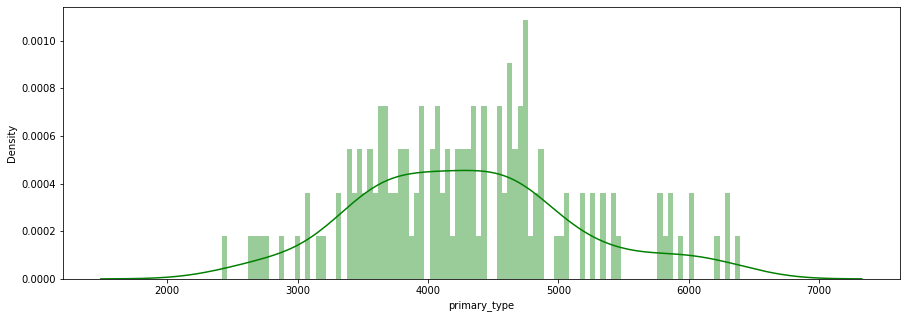

In [129]:
plt.figure(figsize=(15, 5))
sns.distplot(battery['primary_type'], color='g', bins=100, hist_kws={'alpha': 0.4})

### Multicollinearity

In [130]:
# Assigning all other independent features to X variable
X = battery.drop(['primary_type', 'date'], axis=1)

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns 
  
# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

# Print results
vif_data.sort_values(by='VIF', ascending=False).head(10)

feature  VIF
0                                 afternoon  inf
159                        residence-garage  inf
147                           park property  inf
148  parking lot / garage (non residential)  inf
149          parking lot/garage(non.resid.)  inf
150                               pawn shop  inf
151   police facility / vehicle parking lot  inf
152         police facility/veh parking lot  inf
153                               pool room  inf
154                               residence  inf

## Data Preparation

In [131]:
# Create train/test splits (using similar Time-Series split)
train_battery = battery[battery['date'] <= '2019-01-01']
test_battery = battery[battery['date'] >= '2018-11-30']

# Create X and y train/test
X_train, y_train = train_battery.drop(['primary_type', 'date'], axis=1), train_battery['primary_type']
X_test, y_test = test_battery.drop(['primary_type', 'date'], axis=1), test_battery['primary_type']

In [132]:
# Scale data and relabelling as 'Z'
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [133]:
# Checking train test split shape
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (108, 232)
y_train shape is: (108,)
Z_test shape is: (33, 232)
y_test shape is: (33,)


### Principal Component Analysis

In [134]:
# Instantiate PCA
battery_pca = PCA(.95)

# Fit model
battery_pca.fit(Z_train)

PCA(n_components=0.95)

In [135]:
Z_train_pca = battery_pca.transform(Z_train)
Z_test_pca = battery_pca.transform(Z_test)

## **Regression Model**

### Simple Linear Regression

In [136]:
lr = LinearRegression()
lr.fit(Z_train_pca, y_train)

LinearRegression()

In [137]:
# Checking scores between train and test
print (f'Linear training score: {lr.score(Z_train_pca, y_train)}')
print (f'Linear test score: {lr.score(Z_test_pca, y_test)}')

Linear training score: 0.9991285848516077
Linear test score: -11.82185395073322


In [138]:
# Cross val score for train data
cross = cross_val_score(lr, Z_train_pca, y_train, cv=5).mean()
print (f'CV Training Score: {cross}')

CV Training Score: 0.9329425887779884


In [139]:
lr.coef_

array([ 1.17701720e+02,  2.07793144e+01,  1.67962152e+01, -8.42718001e+00,
       -7.55565433e+00,  4.08448582e+00, -2.54533947e+00, -9.25637350e+00,
       -4.74654456e+00,  5.94642570e+00,  3.09218572e+00, -1.16482859e+01,
        6.50075641e+00, -1.72756964e+00,  2.37583446e+00,  1.24985842e+00,
       -3.65093636e+00,  1.38196089e-01, -3.55039873e+00, -6.46357491e-01,
        3.91332634e+00, -1.71143521e+00,  1.45190599e+00,  6.74973670e+00,
        9.26082019e-01,  3.28574826e+00,  5.34612908e+00, -6.56856354e-01,
       -9.31474612e+00, -8.13231597e+00,  6.58840413e-02, -8.14187772e+00,
        8.41481674e+00, -5.42469882e+00,  5.13908230e+00, -4.99154249e+00,
        3.44114404e+00, -2.15482220e+00,  8.56742889e+00,  3.69194915e+00,
        1.40535764e+00,  1.63754707e+00, -3.98120721e+00, -6.68908858e+00,
        1.41307217e+00, -2.92042766e+00, -7.26863285e+00, -5.84546393e+00,
        2.46318038e+00, -1.93278241e-01, -7.70625162e-01,  9.31600996e+00,
       -2.18098694e+00, -

In [140]:
# Finding prediction values
y_preds = lr.predict(Z_test_pca)

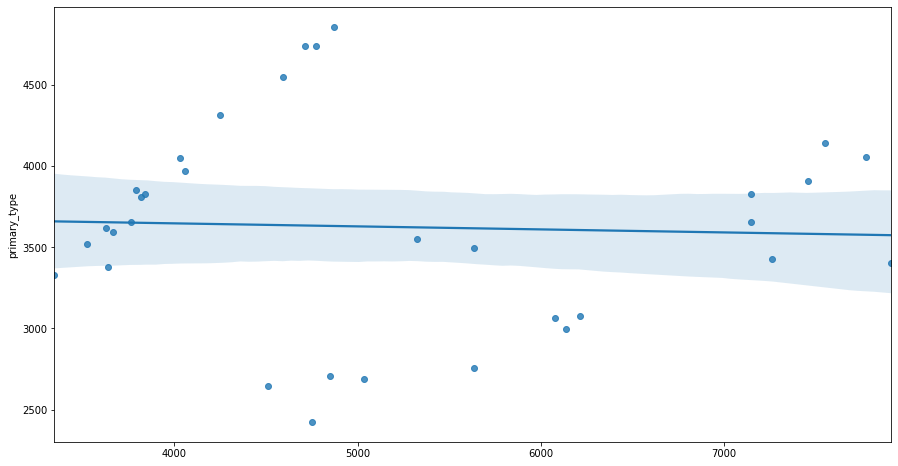

In [141]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds, y_test);

In [142]:
# Evaluation
mse_lr = mean_squared_error(y_test, y_preds)
print (f'MSE Score: {mse_lr}')

rmse_lr = mean_squared_error(y_test, y_preds, squared=False)
print (f'RMSE Score: {rmse_lr}')

mape_lr = mean_absolute_percentage_error(y_test, y_preds)
print (f'MAPE score: {mape_lr}')

MSE Score: 4860073.088404035
RMSE Score: 2204.5573452292037
MAPE score: 0.4751576403790833


In [143]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['lr_predictions'] = pd.Series(y_preds)

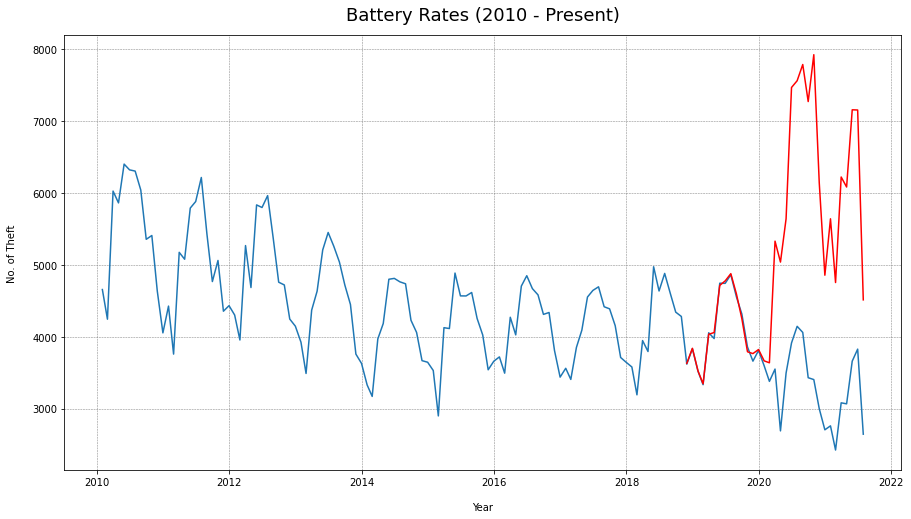

In [144]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='lr_predictions', color='red')

plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Ridge Regression

In [145]:
# Finding best ridge alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(Z_train_pca, y_train)

print (optimal_ridge.alpha_)

34.09285069746813


In [146]:
# Instantiate ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Z_train_pca, y_train, cv=5)

print (f'Ridge training Cross Val Score: {np.mean(ridge_scores)}')

Ridge training Cross Val Score: 0.9868344387357485


In [147]:
# Fit model
ridge.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Ridge training score: {ridge.score(Z_train_pca, y_train)}')
print (f'Ridge test score: {ridge.score(Z_test_pca, y_test)}')

Ridge training score: 0.998920712732658
Ridge test score: -6.196266113532906


In [148]:
ridge.coef_

array([ 1.16826038e+02,  2.04538043e+01,  1.62375376e+01, -7.98595309e+00,
       -7.05853465e+00,  3.80086784e+00, -2.35900173e+00, -8.57630875e+00,
       -4.36716870e+00,  5.44757044e+00,  2.82497510e+00, -1.05684777e+01,
        5.88778041e+00, -1.55670663e+00,  2.13632254e+00,  1.12126988e+00,
       -3.27096012e+00,  1.23415536e-01, -3.16021115e+00, -5.72558788e-01,
        3.46251561e+00, -1.50980341e+00,  1.27957383e+00,  5.91420282e+00,
        8.10762806e-01,  2.85468291e+00,  4.63029884e+00, -5.66356985e-01,
       -8.00620459e+00, -6.97865665e+00,  5.58709653e-02, -6.88334881e+00,
        7.09244365e+00, -4.55858720e+00,  4.29897670e+00, -4.15964480e+00,
        2.85797713e+00, -1.77814854e+00,  7.03303303e+00,  3.01396898e+00,
        1.14244576e+00,  1.32022263e+00, -3.18802574e+00, -5.34040178e+00,
        1.12722953e+00, -2.30953085e+00, -5.68875317e+00, -4.56056547e+00,
        1.91716949e+00, -1.50031521e-01, -5.94985987e-01,  7.12651989e+00,
       -1.64417979e+00, -

In [149]:
# Finding ridge predictions
y_preds_r = ridge.predict(Z_test_pca)

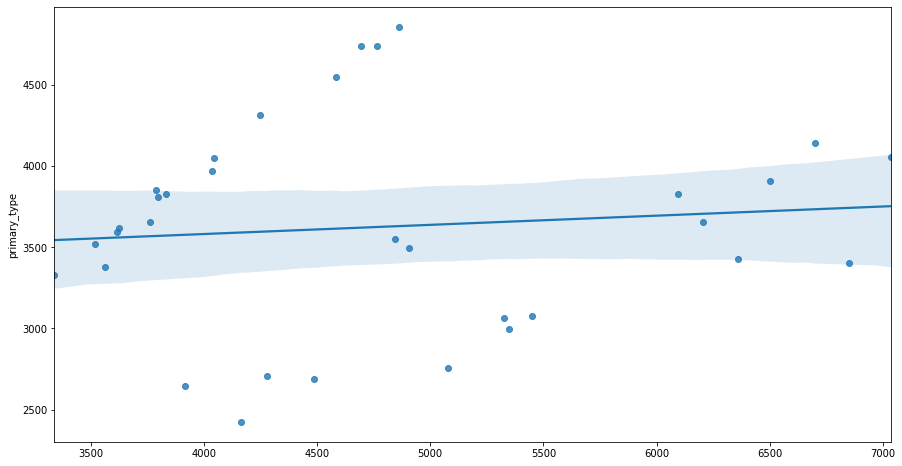

In [150]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_r, y_test);

In [151]:
# Evaluation
mse_ridge = mean_squared_error(y_test, y_preds_r)
print (f'MSE Score: {mse_ridge}')

rmse_ridge = mean_squared_error(y_test, y_preds_r, squared=False)
print (f'RMSE Score: {rmse_ridge}')

mape_ridge = mean_absolute_percentage_error(y_test, y_preds_r)
print (f'MAPE score: {mape_ridge}')

MSE Score: 2727716.242109836
RMSE Score: 1651.5799230160908
MAPE score: 0.35445493174610326


In [152]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['ridge_predictions'] = pd.Series(y_preds_r)

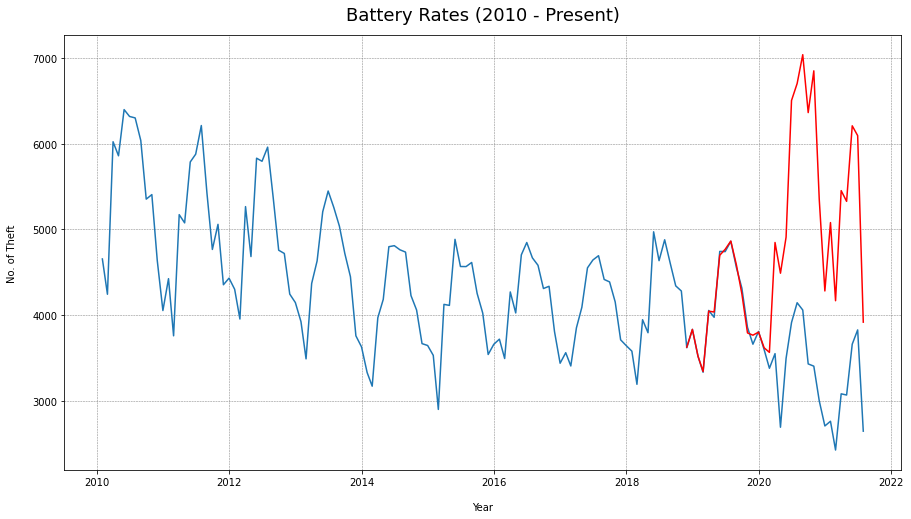

In [153]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='ridge_predictions', color='red')

plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Lasso Regression

In [154]:
# Finding best lasso alpha
optimal_lasso = LassoCV(n_alphas=20, cv=5, max_iter=10000)
optimal_lasso.fit(Z_train_pca, y_train)

print (optimal_lasso.alpha_)

14.753657968364134


In [155]:
# Instantiate Lasso regression
lasso = Lasso(alpha=optimal_lasso.alpha_, max_iter=10000)
lasso_scores = cross_val_score(lasso, Z_train_pca, y_train, cv=5)

print (f'Lasso training Cross Val Score: {np.mean(lasso_scores)}')

Lasso training Cross Val Score: 0.9887693134169666


In [156]:
# Fit model
lasso.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Lasso training score: {lasso.score(Z_train_pca, y_train)}')
print (f'Lasso test score: {lasso.score(Z_test_pca, y_test)}')

Lasso training score: 0.9951952987466506
Lasso test score: 0.4568888540924205


In [157]:
lasso.coef_

array([117.35139832,  20.03552412,  15.1881588 ,  -5.84494719,
        -4.26405812,   0.59701042,  -0.        ,  -5.55033433,
        -0.6865086 ,   1.66654319,   0.        ,  -6.87305558,
         1.63498144,  -0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   0.14693879,
         0.        ,   0.        ,   0.        ,  -0.        ,
        -1.67601938,  -0.40611683,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,   0.  

In [158]:
# Finding lasso predictions
y_preds_l = lasso.predict(Z_test_pca)

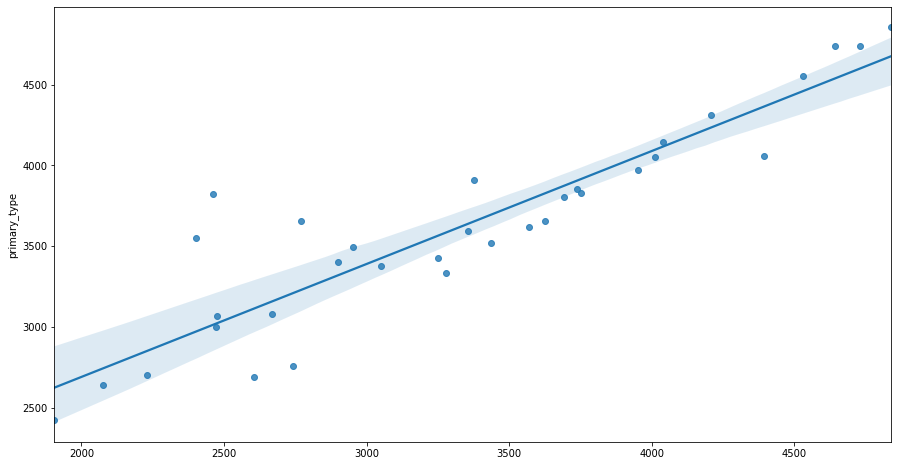

In [159]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_l, y_test);

In [160]:
# Evaluation
mse_lasso = mean_squared_error(y_test, y_preds_l)
print (f'MSE Score: {mse_lasso}')

rmse_lasso = mean_squared_error(y_test, y_preds_l, squared=False)
print (f'RMSE Score: {rmse_lasso}')

mape_lasso = mean_absolute_percentage_error(y_test, y_preds_l)
print (f'MAPE score: {mape_lasso}')

MSE Score: 205864.13434281555
RMSE Score: 453.722530124762
MAPE score: 0.0920817651943384


In [161]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['lasso_predictions'] = pd.Series(y_preds_l)

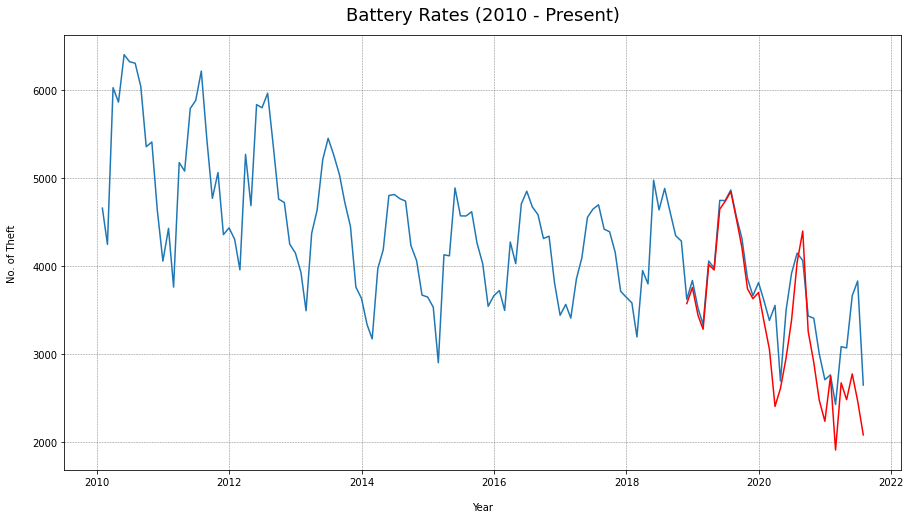

In [162]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='lasso_predictions', color='red')

plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

## **Ensemble Methods**

### Random Forest

In [163]:
# Instantiate Random Forest Regression
rf = RandomForestRegressor()

# Fit model
rf.fit(Z_train, y_train)

RandomForestRegressor()

In [164]:
# Scores for train and test data
print (f'Random Forest training score: {rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {rf.score(Z_test, y_test)}')

Random Forest training score: 0.997888865587081
Random Forest test score: 0.8275208109656694


In [165]:
rf_scores = cross_val_score(rf, Z_train, y_train, cv=5)

print (f'Random Forest training Cross Val Score: {np.mean(rf_scores)}')

Random Forest training Cross Val Score: 0.942703563533143


In [166]:
# Finding lasso predictions
y_preds_rf = rf.predict(Z_test)

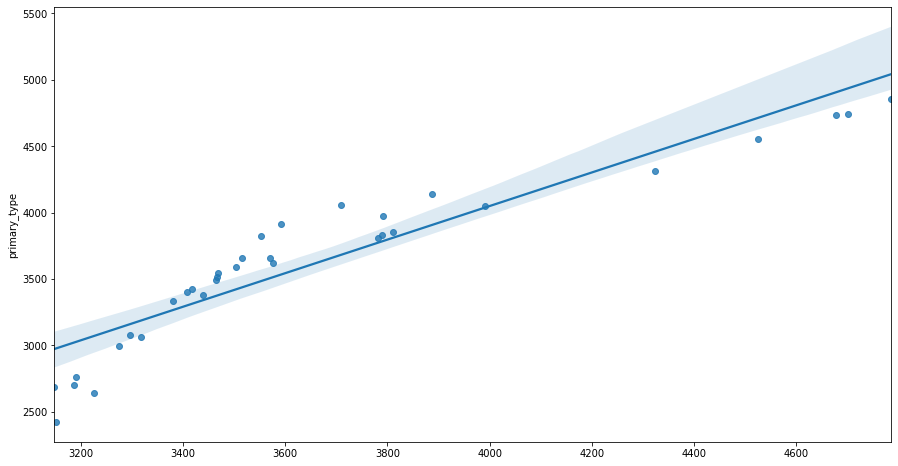

In [167]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf, y_test);

In [168]:
# Evaluation
mse_rf = mean_squared_error(y_test, y_preds_rf)
print (f'MSE Score: {mse_rf}')

rmse_rf = mean_squared_error(y_test, y_preds_rf, squared=False)
print (f'RMSE Score: {rmse_rf}')

mape_rf = mean_absolute_percentage_error(y_test, y_preds_rf)
print (f'MAPE score: {mape_rf}')

MSE Score: 65377.55523939394
RMSE Score: 255.6903503055873
MAPE score: 0.05726032396927567


In [169]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['rf_predictions'] = pd.Series(y_preds_rf)

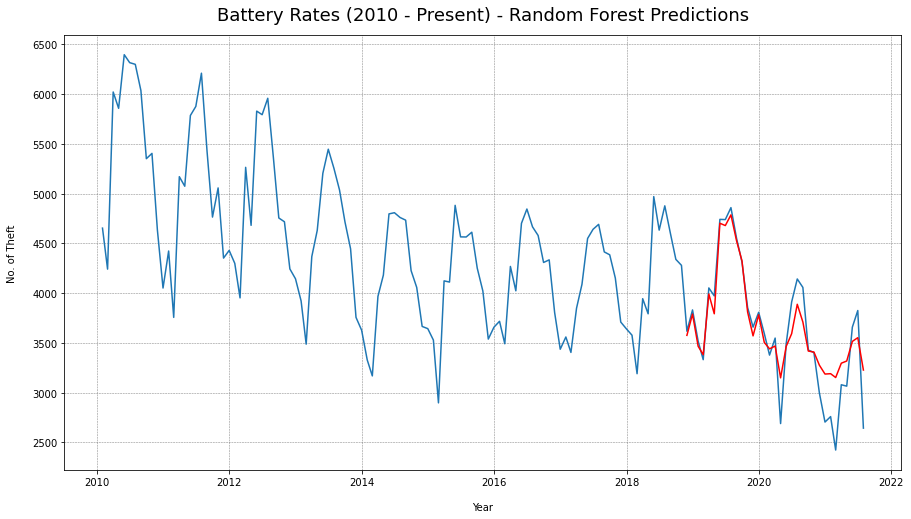

In [170]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='rf_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [171]:
# Instantiate Random Forest Regression
rf2 = RandomForestRegressor()

# Assign hyperparameters
rf_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [172]:
# Instatntiate GridsearchCV
gs_rf = GridSearchCV(rf2, param_grid=rf_params, cv=5, verbose=2)

# Fit model
gs_rf.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_rf.best_score_}')
print(f'Best parameters: {gs_rf.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=150; total time=   0.6s
[CV] END ...............min_samples_leaf=1, n_e

In [173]:
# Scores for train and test data
print (f'Random Forest training score: {gs_rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {gs_rf.score(Z_test, y_test)}')

Random Forest training score: 0.9976010948095217
Random Forest test score: 0.826066908239792


In [174]:
y_preds_rf3 = gs_rf.predict(Z_test)

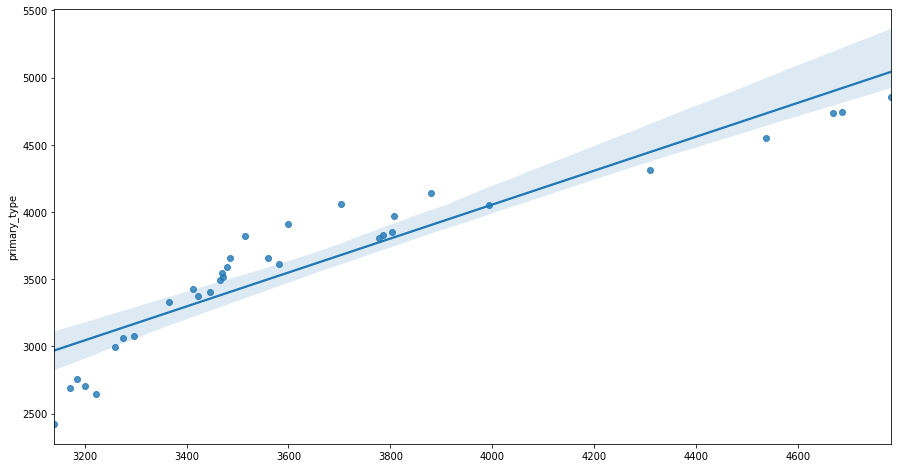

In [175]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf3, y_test);

In [176]:
# Evaluation
mse_rf3 = mean_squared_error(y_test, y_preds_rf3)
print (f'MSE Score: {mse_rf3}')

rmse_rf3 = mean_squared_error(y_test, y_preds_rf3, squared=False)
print (f'RMSE Score: {rmse_rf3}')

mape_rf3 = mean_absolute_percentage_error(y_test, y_preds_rf3)
print (f'MAPE score: {mape_rf3}')

MSE Score: 65928.65132412122
RMSE Score: 256.76575185199687
MAPE score: 0.05769080993061928


In [177]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['rf3_predictions'] = pd.Series(y_preds_rf3)

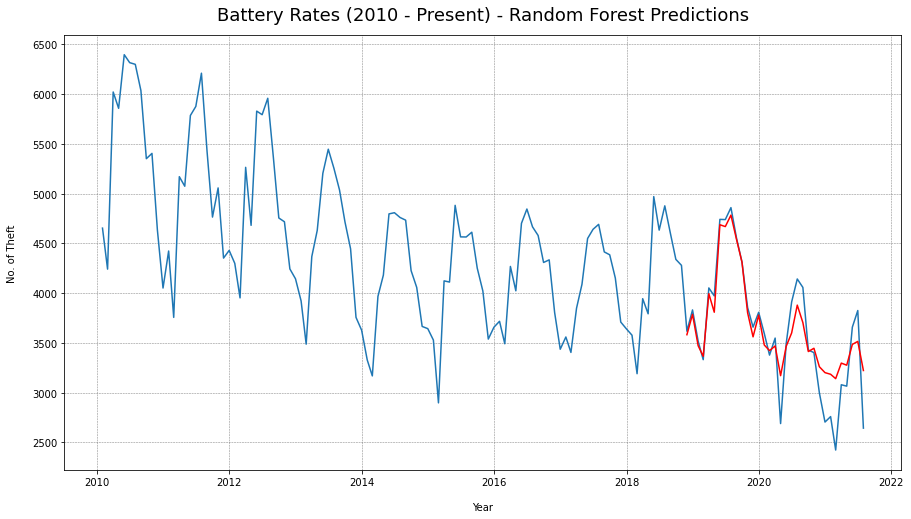

In [178]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='rf3_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Gradient Boost

In [179]:
# Instantiate Random Forest Regression
gb = GradientBoostingRegressor()

# Fit model
gb.fit(Z_train, y_train)

GradientBoostingRegressor()

In [180]:
# Scores for train and test data
print (f'Gradient Boosting training score: {gb.score(Z_train, y_train)}')
print (f'Gradient Boosting test score: {gb.score(Z_test, y_test)}')

Gradient Boosting training score: 0.9999968693960191
Gradient Boosting test score: 0.8848848503541579


In [181]:
gb_scores = cross_val_score(gb, Z_train, y_train, cv=5)

print (f'Gradient Boosting training Cross Val Score: {np.mean(gb_scores)}')

Gradient Boosting training Cross Val Score: 0.9607045855022903


In [182]:
# Finding lasso predictions
y_preds_gb = gb.predict(Z_test)

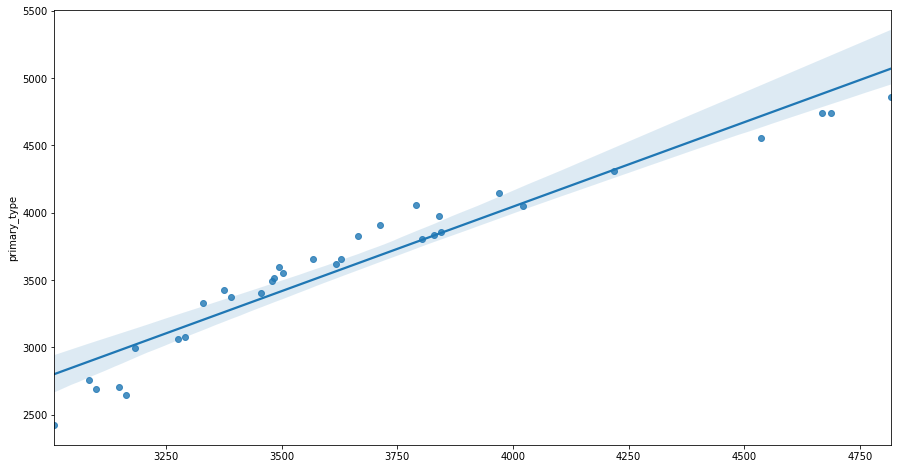

In [183]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb, y_test);

In [184]:
# Evaluation
mse_gb = mean_squared_error(y_test, y_preds_gb)
print (f'MSE Score: {mse_gb}')

rmse_gb = mean_squared_error(y_test, y_preds_gb, squared=False)
print (f'RMSE Score: {rmse_gb}')

mape_gb = mean_absolute_percentage_error(y_test, y_preds_gb)
print (f'MAPE score: {mape_gb}')

MSE Score: 43633.94272084713
RMSE Score: 208.88739244111198
MAPE score: 0.04542840352288592


In [185]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['gb_predictions'] = pd.Series(y_preds_gb)

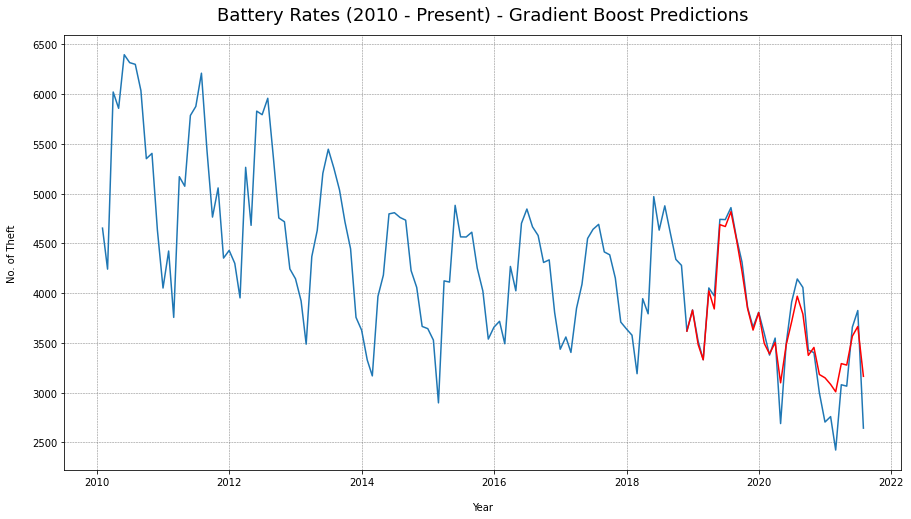

In [186]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='gb_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [187]:
# Instantiate Random Forest Regression
gb2 = GradientBoostingRegressor()

# Assign hyperparameters
gb_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'learning_rate': [.05, .1, .15, .2, .3]
}

In [188]:
# Instatntiate GridsearchCV
gs_gb = GridSearchCV(gb2, param_grid=gb_params, cv=5, verbose=2)

# Fit model
gs_gb.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_gb.best_score_}')
print(f'Best parameters: {gs_gb.best_params_}')

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.3s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=150; total time

In [189]:
# Scores for train and test data
print (f'Gradient Boost training score: {gs_gb.score(Z_train, y_train)}')
print (f'Gradient Boost test score: {gs_gb.score(Z_test, y_test)}')

Gradient Boost training score: 0.9999996107732096
Gradient Boost test score: 0.9011987403640181


In [190]:
y_preds_gb3 = gs_gb.predict(Z_test)

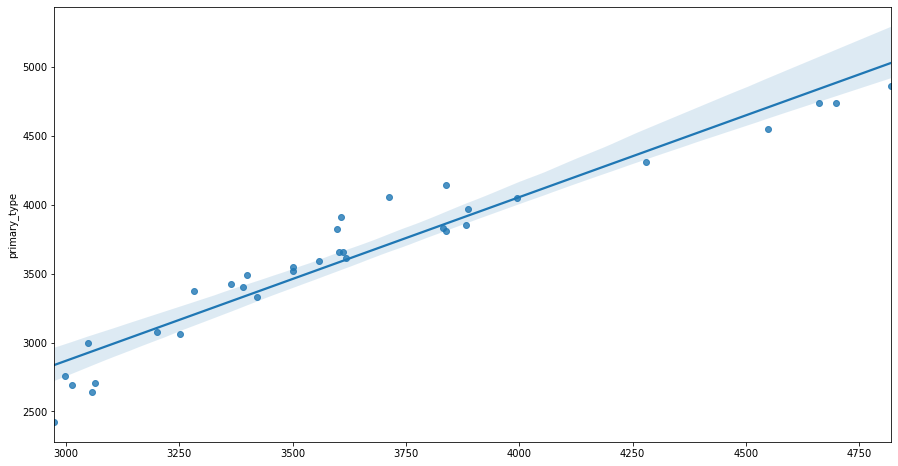

In [191]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb3, y_test);

In [192]:
# Evaluation
mse_gb3 = mean_squared_error(y_test, y_preds_gb3)
print (f'MSE Score: {mse_gb3}')

rmse_gb3 = mean_squared_error(y_test, y_preds_gb3, squared=False)
print (f'RMSE Score: {rmse_gb3}')

mape_gb3 = mean_absolute_percentage_error(y_test, y_preds_gb3)
print (f'MAPE score: {mape_gb3}')

MSE Score: 37450.22715921641
RMSE Score: 193.5206117167275
MAPE score: 0.042068036673561876


In [193]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['gb3_predictions'] = pd.Series(y_preds_gb3)

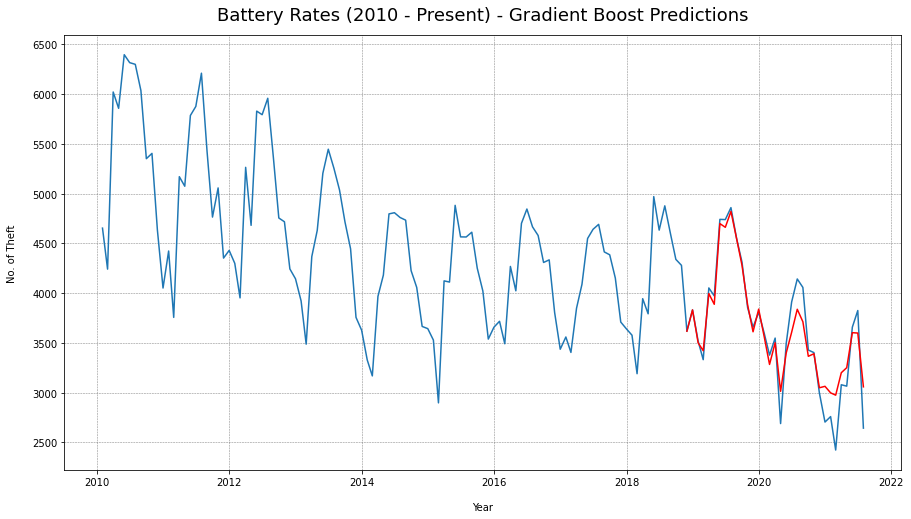

In [194]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='gb3_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ADA Boost



In [195]:
# Instantiate Random Forest Regression
ab = AdaBoostRegressor()

# Fit model
ab.fit(Z_train, y_train)

AdaBoostRegressor()

In [196]:
# Scores for train and test data
print (f'ADA Boosting training score: {ab.score(Z_train, y_train)}')
print (f'ADA Boosting test score: {ab.score(Z_test, y_test)}')

ADA Boosting training score: 0.994958574575785
ADA Boosting test score: 0.8578512338554025


In [197]:
ab_scores = cross_val_score(ab, Z_train, y_train, cv=5)

print (f'ADA Boosting training Cross Val Score: {np.mean(ab_scores)}')

ADA Boosting training Cross Val Score: 0.9511268555446218


In [198]:
# Finding lasso predictions
y_preds_ab = ab.predict(Z_test)

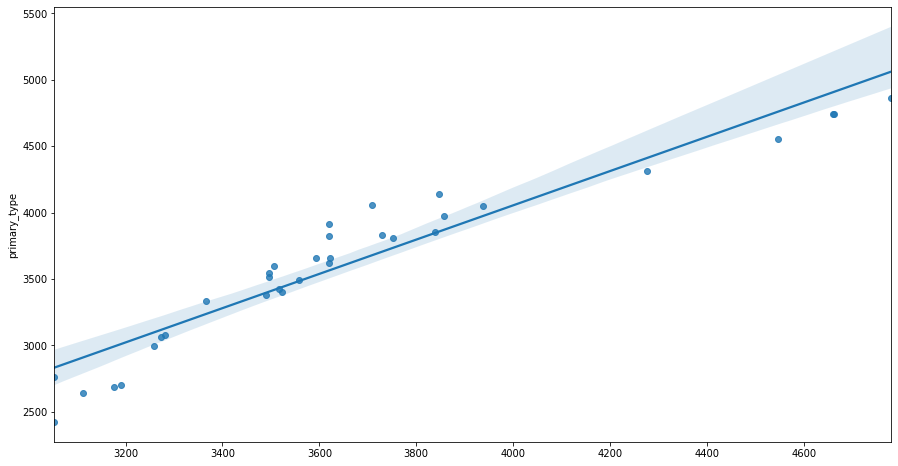

In [199]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab, y_test);

In [200]:
# Evaluation
mse_ab = mean_squared_error(y_test, y_preds_ab)
print (f'MSE Score: {mse_ab}')

rmse_ab = mean_squared_error(y_test, y_preds_ab, squared=False)
print (f'RMSE Score: {rmse_ab}')

mape_ab = mean_absolute_percentage_error(y_test, y_preds_ab)
print (f'MAPE score: {mape_ab}')

MSE Score: 53880.928260744266
RMSE Score: 232.1226577926943
MAPE score: 0.053549259186893294


In [201]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['ab_predictions'] = pd.Series(y_preds_ab)

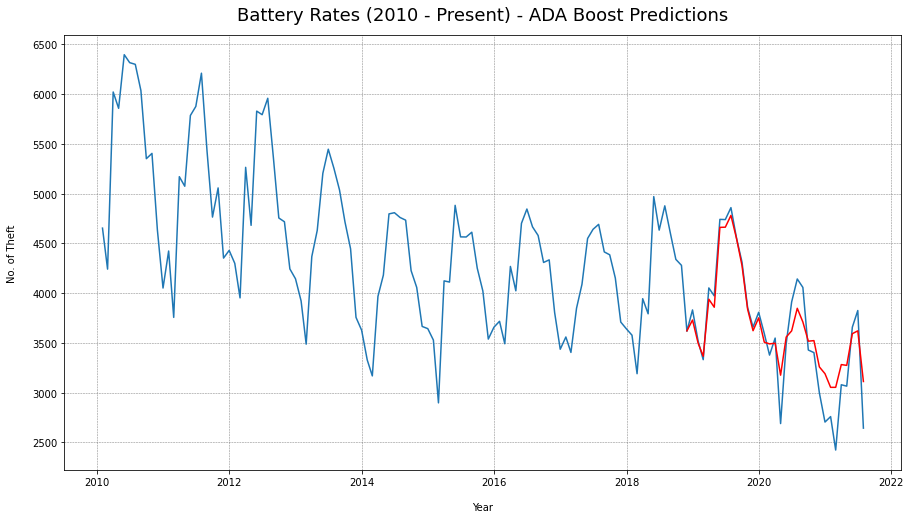

In [202]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='ab_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [203]:
# Instantiate Random Forest Regression
ab2 = AdaBoostRegressor()

# Assign hyperparameters
ab_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3]
}

In [204]:
# Instatntiate GridsearchCV
gs_ab = GridSearchCV(ab2, param_grid=ab_params, cv=5)

# Fit model
gs_ab.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_ab.best_score_}')
print(f'Best parameters: {gs_ab.best_params_}')

Best Gridserach score: 0.9573511803480198
Best parameters: {'learning_rate': 0.3, 'n_estimators': 200}


In [205]:
# Scores for train and test data
print (f'Random Forest training score: {gs_ab.score(Z_train, y_train)}')
print (f'Random Forest test score: {gs_ab.score(Z_test, y_test)}')

Random Forest training score: 0.9952716846617458
Random Forest test score: 0.870462731946655


In [206]:
y_preds_ab3 = gs_ab.predict(Z_test)

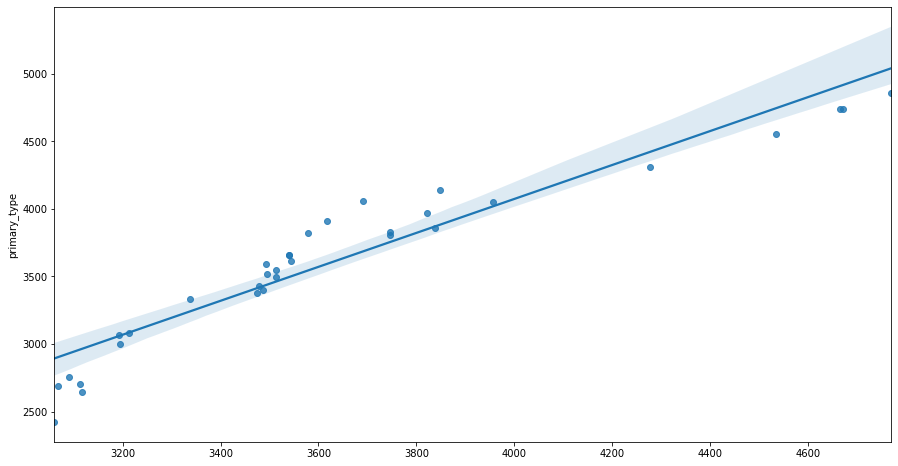

In [207]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab3, y_test);

In [208]:
# Evaluation
mse_ab3 = mean_squared_error(y_test, y_preds_ab3)
print (f'MSE Score: {mse_ab3}')

rmse_ab3 = mean_squared_error(y_test, y_preds_ab3, squared=False)
print (f'RMSE Score: {rmse_ab3}')

mape_ab3 = mean_absolute_percentage_error(y_test, y_preds_ab3)
print (f'MAPE score: {mape_ab3}')

MSE Score: 49100.5897298838
RMSE Score: 221.58652876446212
MAPE score: 0.05079665770001641


In [209]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['ab3_predictions'] = pd.Series(y_preds_ab3)

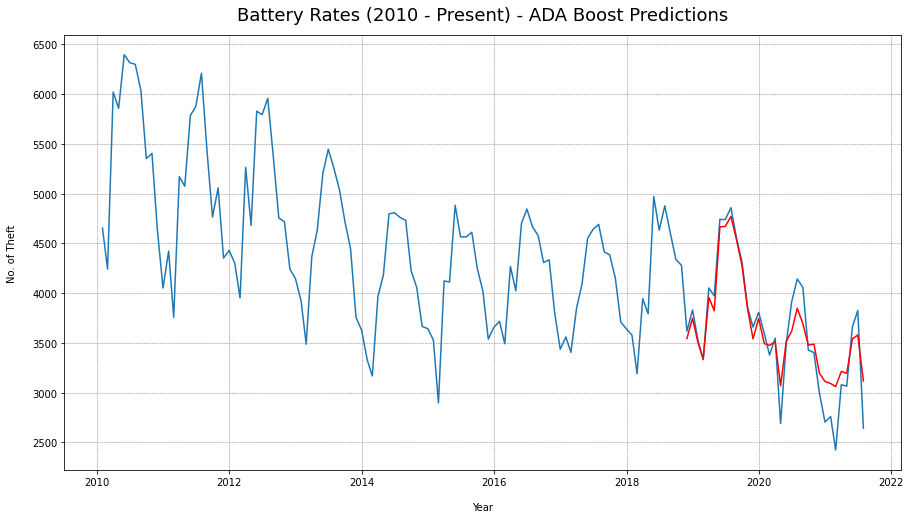

In [210]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='ab3_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### XGBoost

In [211]:
# Instantiate Random Forest Regression
xg = XGBRegressor()

# Fit model
xg.fit(Z_train, y_train)

[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [212]:
# Scores for train and test data
print (f'XG Boosting training score: {xg.score(Z_train, y_train)}')
print (f'XG Boosting test score: {xg.score(Z_test, y_test)}')

XG Boosting training score: 0.9999564830760503
XG Boosting test score: 0.9369395134930345


In [213]:
xg_scores = cross_val_score(xg, Z_train, y_train, cv=5)

print (f'XG Boosting training Cross Val Score: {np.mean(xg_scores)}')

[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boosting training Cross Val Score: 0.9603116822748049


In [214]:
# Finding lasso predictions
y_preds_xg = xg.predict(Z_test)

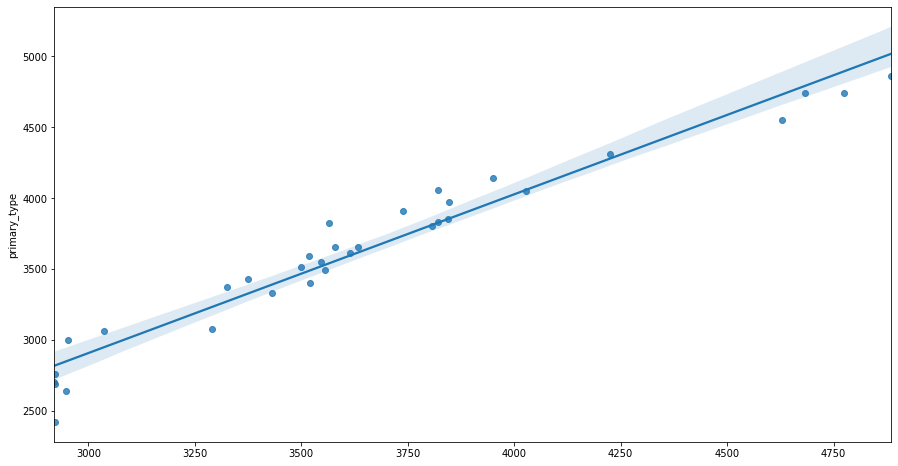

In [215]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg, y_test);

In [216]:
# Evaluation
mse_xg = mean_squared_error(y_test, y_preds_xg)
print (f'MSE Score: {mse_xg}')

rmse_xg = mean_squared_error(y_test, y_preds_xg, squared=False)
print (f'RMSE Score: {rmse_xg}')

mape_xg = mean_absolute_percentage_error(y_test, y_preds_xg)
print (f'MAPE score: {mape_xg}')

MSE Score: 23902.82829548554
RMSE Score: 154.6053954281206
MAPE score: 0.03429038622336547


In [217]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['xg_predictions'] = pd.Series(y_preds_xg)

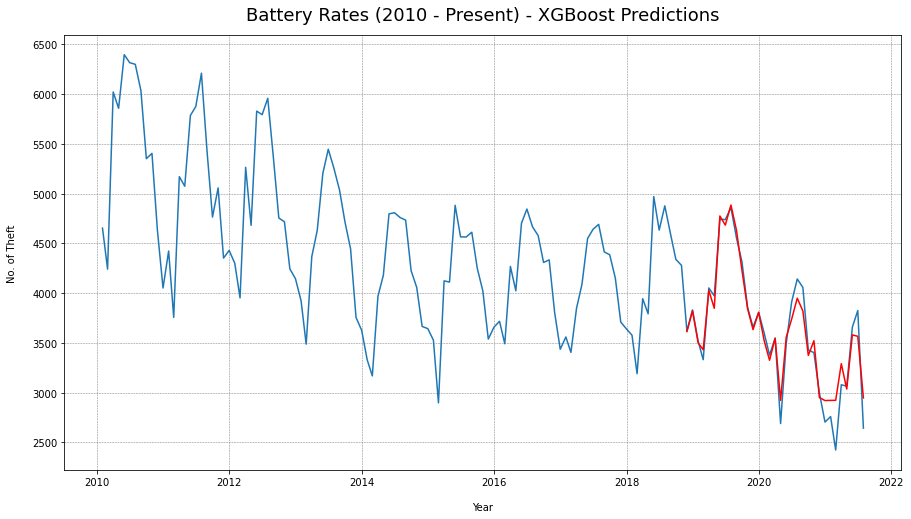

In [218]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='xg_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [219]:
# Instantiate Random Forest Regression
xg2 = XGBRegressor()

# Assign hyperparameters
xg_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3],
    'lambda': [1, 2, 3]
}

In [220]:
# Instatntiate GridsearchCV
gs_xg = GridSearchCV(xg2, param_grid=xg_params, cv=5, verbose=2)

# Fit model
gs_xg.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_xg.best_score_}')
print(f'Best parameters: {gs_xg.best_params_}')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

In [221]:
# Scores for train and test data
print (f'Adaptive Boost training score: {gs_xg.score(Z_train, y_train)}')
print (f'Adaptive Boost test score: {gs_xg.score(Z_test, y_test)}')

Adaptive Boost training score: 0.9999577526943656
Adaptive Boost test score: 0.9361128017246603


In [222]:
y_preds_xg3 = gs_xg.predict(Z_test)

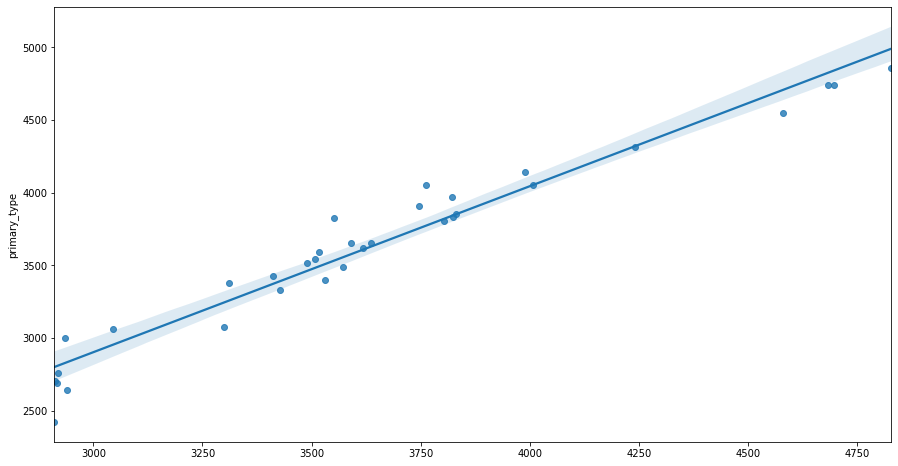

In [223]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg3, y_test);

In [224]:
# Evaluation
mse_xg3 = mean_squared_error(y_test, y_preds_xg3)
print (f'MSE Score: {mse_xg3}')

rmse_xg3 = mean_squared_error(y_test, y_preds_xg3, squared=False)
print (f'RMSE Score: {rmse_xg3}')

mape_xg3 = mean_absolute_percentage_error(y_test, y_preds_xg3)
print (f'MAPE score: {mape_xg3}')

MSE Score: 24216.19012543469
RMSE Score: 155.61552019459592
MAPE score: 0.03465607850708874


In [225]:
test_battery = test_battery.reset_index().drop('index', axis=1)
test_battery['xg3_predictions'] = pd.Series(y_preds_xg3)

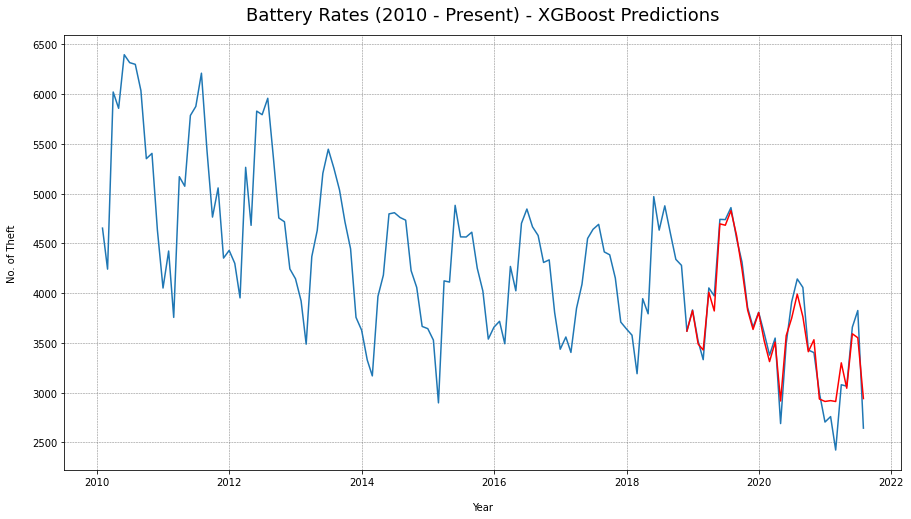

In [226]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=battery, x='date', y='primary_type')
sns.lineplot(data=test_battery, x='date', y='xg3_predictions', color='red')

plt.title('Battery Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ***Based on regression model:***

|Model|RMSE|MAE|
|---|---|---|
|Linear Regression|2204.557345229202|0.4751576403790831|
|Lasso Regression|453.7225301247614|0.09208176519433821|
|Ridge Regression|1651.5799230160903|0.35445493174610315|
|Random Forest|257.1925353070868|0.05697204143143295|
|Gradient Boost|201.102148939374|0.04394032528422916|
|Adaptive Boost|230.3587150338753|0.053935081007841945|
|XG Boost|155.61552019459592|0.03465607850708874|

# **Criminal Damage Crime**


In [227]:
cridmg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone/assets/clean_data/2010_2021_cridmg_monthly.csv')

## Data Summary

In [228]:
cridmg.head()

date  primary_type  afternoon  ...  45to54  65to74  75andmore
0  2010-01-31          2788        757  ...  342384  151070     129473
1  2010-02-28          2444        562  ...  342384  151070     129473
2  2010-03-31          3751        902  ...  342384  151070     129473
3  2010-04-30          3841        911  ...  342384  151070     129473
4  2010-05-31          3800        880  ...  342384  151070     129473

[5 rows x 193 columns]

In [229]:
# Summary information of data
cridmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Columns: 193 entries, date to 75andmore
dtypes: float64(2), int64(190), object(1)
memory usage: 227.8+ KB


In [230]:
# Check rows and columns
cridmg.shape

(151, 193)

In [231]:
cridmg.describe()

primary_type   afternoon  ...         65to74      75andmore
count    151.000000  151.000000  ...     151.000000     151.000000
mean    2334.516556  580.112583  ...  173484.443709  134356.185430
std      854.264813  203.988155  ...   17698.012191    5399.737082
min        0.000000    0.000000  ...  151070.000000  128806.000000
25%     2071.000000  532.500000  ...  155402.000000  129643.000000
50%     2453.000000  606.000000  ...  173431.000000  131668.000000
75%     2735.500000  696.500000  ...  195049.000000  141920.000000
max     3841.000000  911.000000  ...  195049.000000  141920.000000

[8 rows x 192 columns]

In [232]:
# Check for null values
cridmg.isnull().sum()

date                                                     0
primary_type                                             0
afternoon                                                0
evening                                                  0
morning                                                  0
night                                                    0
criminal defacement                                      0
institutional vandalism                                  0
library vandalism                                        0
to city of chicago property                              0
to fire fight.app.equip                                  0
to property                                              0
to state sup prop                                        0
to state supported property                              0
to vehicle                                               0
abandoned building                                       0
aircraft                                                

In [233]:
# Change columns to lower string
cridmg.columns = cridmg.columns.str.lower()

In [234]:
# Change dtype to datetime
cridmg['date'] = pd.to_datetime(cridmg['date'], format='%Y-%m-%d')

In [235]:
# Change dtype to int
for feature in cridmg.columns:
  if feature == 'avg_temp' or feature == 'unemployment_rate':
    continue
  else:
    if cridmg[feature].dtype == 'float64':
      cridmg[feature] = cridmg[feature].astype('int64')
    else:
      continue

In [236]:
# Removing forecast dates (Only for SARIMXA purposes)
cridmg = cridmg[:-12]

In [237]:
# Save checkpoint
cridmg_ori = cridmg.copy()

## Understanding Theft Rates

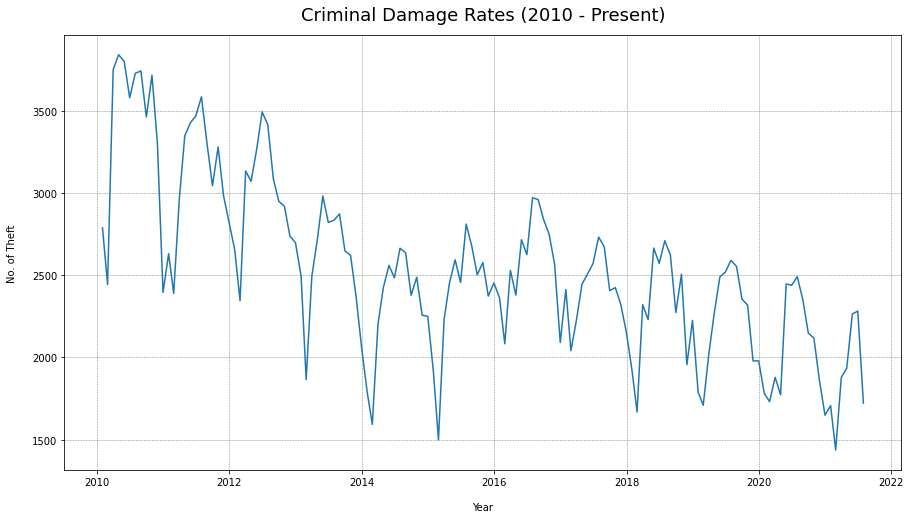

In [238]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')

plt.title('Criminal Damage Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Correlation

In [239]:
# Correlation against 'primary_type' >= 0.5
abs(cridmg.corr()['primary_type']).sort_values(ascending=False).head(80)

primary_type                         1.000000
evening                              0.981450
street                               0.979081
to vehicle                           0.978309
to property                          0.976065
afternoon                            0.963638
residence                            0.953357
night                                0.935766
morning                              0.934240
district_25                          0.907132
district_14                          0.903963
district_4                           0.902374
district_7                           0.898625
district_8                           0.891033
district_16                          0.870659
district_22                          0.864932
district_12                          0.860669
district_10                          0.856663
district_3                           0.856431
district_19                          0.848214
district_9                           0.846790
arrest_true                       

Text(0.5, 1.0, 'Correlation Heatmap for Criminal Damage')

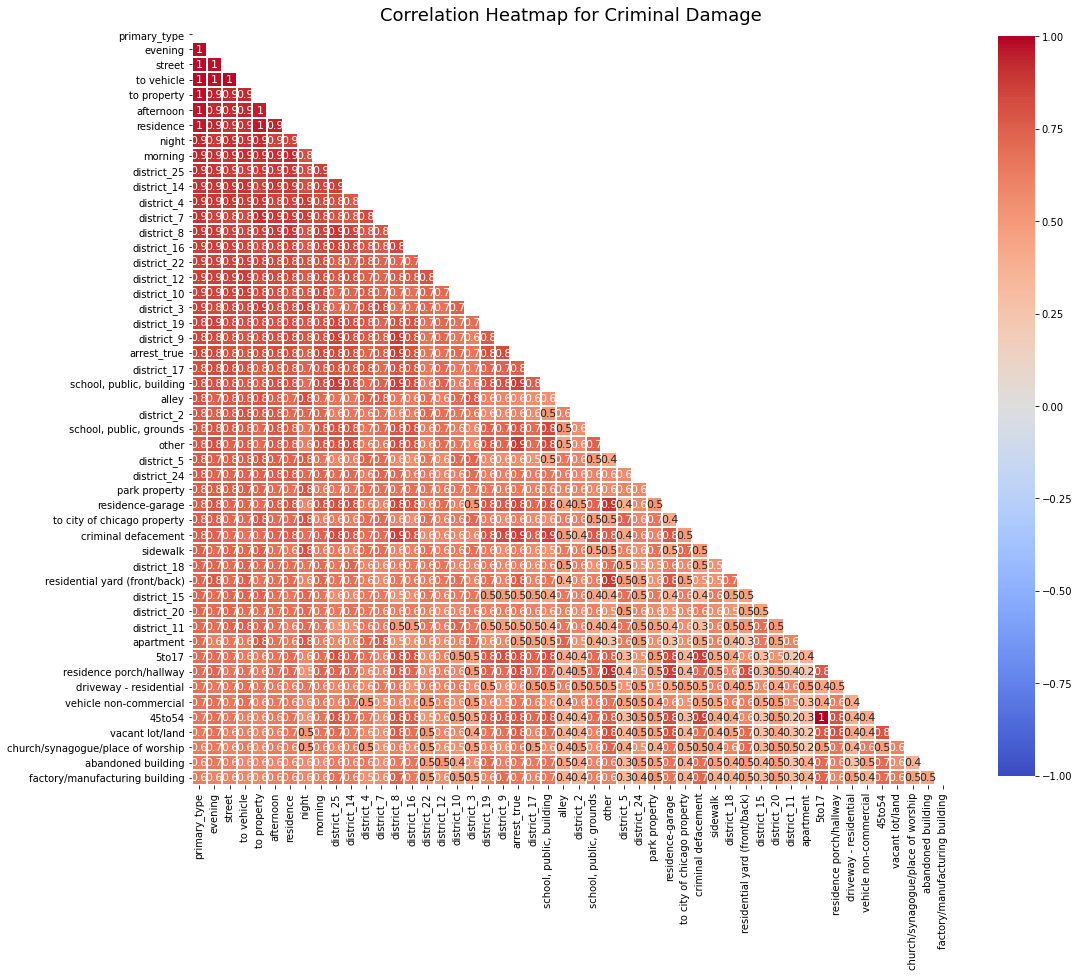

In [240]:
# Plot correlation via heatmap
k = 50
corrmat = cridmg.corr()
  
cols = corrmat.nlargest(k, 'primary_type')['primary_type'].index
  
cm = np.corrcoef(cridmg[cols].values.T)
f, ax = plt.subplots(figsize =(17, 17))

mask = np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cm, ax = ax, cmap ="coolwarm", annot=True, linewidths = 0.1, 
            yticklabels = cols.values, xticklabels = cols.values,
            mask=mask, vmin=-1, vmax=1,square=True, linewidth=1, annot_kws={'size':'11'},
            cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

plt.title('Correlation Heatmap for Criminal Damage', fontsize=18)


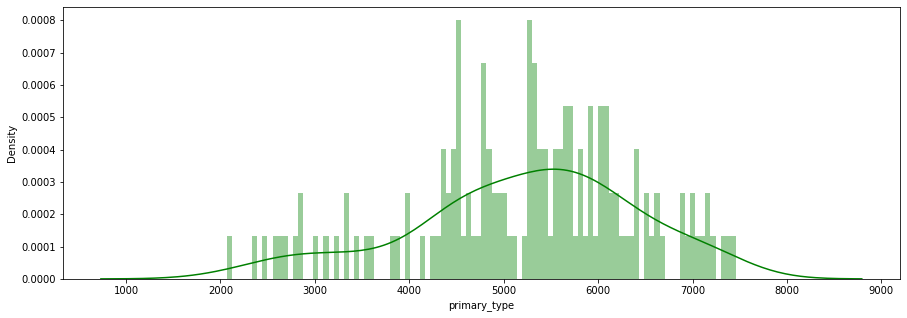

In [241]:
plt.figure(figsize=(15, 5))
sns.distplot(theft['primary_type'], color='g', bins=100, hist_kws={'alpha': 0.4})

### Multicollinearity

In [242]:
# Assigning all other independent features to X variable
X = theft.drop(['primary_type', 'date'], axis=1)

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns 
  
# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

# Print results
vif_data.sort_values(by='VIF', ascending=False).head(20)

feature  VIF
0                                          afternoon  inf
138                         school, public, building  inf
128                                 residence-garage  inf
129                    residential yard (front/back)  inf
130                                       restaurant  inf
131                                 savings and loan  inf
132                        school - private building  inf
133                         school - private grounds  inf
134                         school - public building  inf
135                          school - public grounds  inf
136                        school, private, building  inf
137                         school, private, grounds  inf
139                          school, public, grounds  inf
151  vehicle - commercial: entertainment / party bus  inf
140                                         sidewalk  inf
141                               small retail store  inf
142                           sports arena / stadium  inf
143                             sports arena/stadium  inf
144                                           street  inf
145                            tavern / liquor store  inf

## Data Preparation

In [243]:
# Create train/test splits (using similar Time-Series split)
train_cridmg = cridmg[cridmg['date'] <= '2019-01-01']
test_cridmg = cridmg[cridmg['date'] >= '2018-11-30']

# Create X and y train/test
X_train, y_train = train_cridmg.drop(['primary_type', 'date'], axis=1), train_cridmg['primary_type']
X_test, y_test = test_cridmg.drop(['primary_type', 'date'], axis=1), test_cridmg['primary_type']

In [244]:
# Scale data and relabelling as 'Z'
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [245]:
# Checking train test split shape
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (108, 191)
y_train shape is: (108,)
Z_test shape is: (33, 191)
y_test shape is: (33,)


### Principal Component Analysis

In [246]:
# Instantiate PCA
cridmg_pca = PCA(.95)

# Fit model
cridmg_pca.fit(Z_train)

PCA(n_components=0.95)

In [247]:
Z_train_pca = cridmg_pca.transform(Z_train)
Z_test_pca = cridmg_pca.transform(Z_test)

## **Regression Model**

### Simple Linear Regression

In [248]:
lr = LinearRegression()
lr.fit(Z_train_pca, y_train)

LinearRegression()

In [249]:
# Checking scores between train and test
print (f'Linear training score: {lr.score(Z_train_pca, y_train)}')
print (f'Linear test score: {lr.score(Z_test_pca, y_test)}')

Linear training score: 0.9985539777258712
Linear test score: -3.2994300323044


In [250]:
# Cross val score for train data
cross = cross_val_score(lr, Z_train_pca, y_train, cv=5).mean()
print (f'CV Training Score: {cross}')

CV Training Score: 0.8062230861065494


In [251]:
lr.coef_

array([ 7.45653886e+01,  2.41446922e+01, -1.04405635e+00,  1.10147940e+01,
       -2.17391060e+00,  7.82282651e-01, -7.69845564e+00,  1.57778960e+00,
        1.74263165e+00,  5.24408721e+00,  1.66906539e+00,  1.89335130e+00,
        5.58357721e-01, -1.62115669e+00, -3.57734483e+00,  3.49223274e+00,
       -1.32003400e+00,  7.64492682e+00,  3.63331988e-01, -7.48559162e+00,
        1.58510682e+00, -1.42836689e+00, -3.42015824e+00,  4.48659503e+00,
       -6.37675257e-01,  1.61722055e+00,  6.11959396e-01, -1.85116455e+00,
        4.99585318e+00,  1.08070745e+00,  4.86280252e-01, -1.24125702e+00,
        2.02828443e+00, -7.46294936e+00,  4.05799705e-02,  8.87751742e+00,
        4.50243886e+00,  3.21325624e+00,  3.15875602e-01,  1.74036640e+00,
        1.24095086e+00,  3.26901984e+00, -5.96640202e-01, -1.58121126e+00,
       -5.04709008e+00, -4.57332651e+00, -2.39749384e-01, -7.81459415e+00,
       -1.31359507e+00, -9.79772723e+00,  5.05908189e+00, -7.63051398e-01,
        1.82152849e+00,  

In [252]:
# Finding prediction values
y_preds = lr.predict(Z_test_pca)

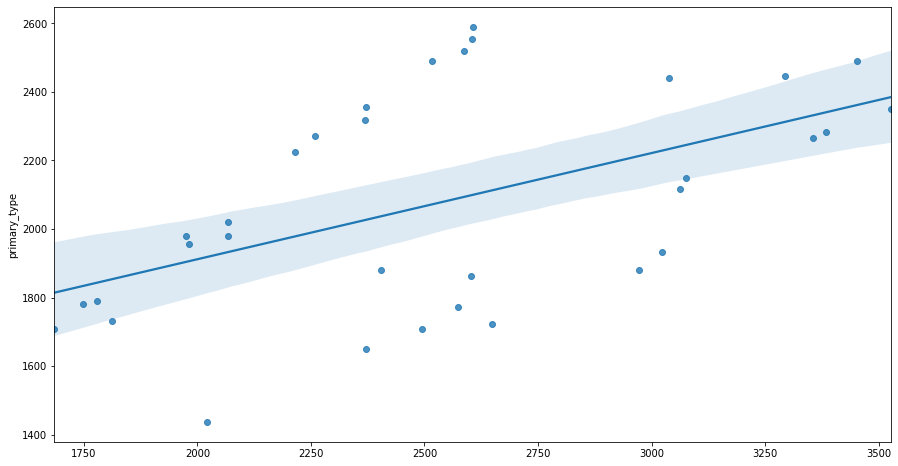

In [253]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds, y_test);

In [254]:
# Evaluation
mse_lr = mean_squared_error(y_test, y_preds)
print (f'MSE Score: {mse_lr}')

rmse_lr = mean_squared_error(y_test, y_preds, squared=False)
print (f'RMSE Score: {rmse_lr}')

mape_lr = mean_absolute_percentage_error(y_test, y_preds)
print (f'MAPE score: {mape_lr}')

MSE Score: 417150.5367538995
RMSE Score: 645.8719197750429
MAPE score: 0.2336701265805929


In [255]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['lr_predictions'] = pd.Series(y_preds)

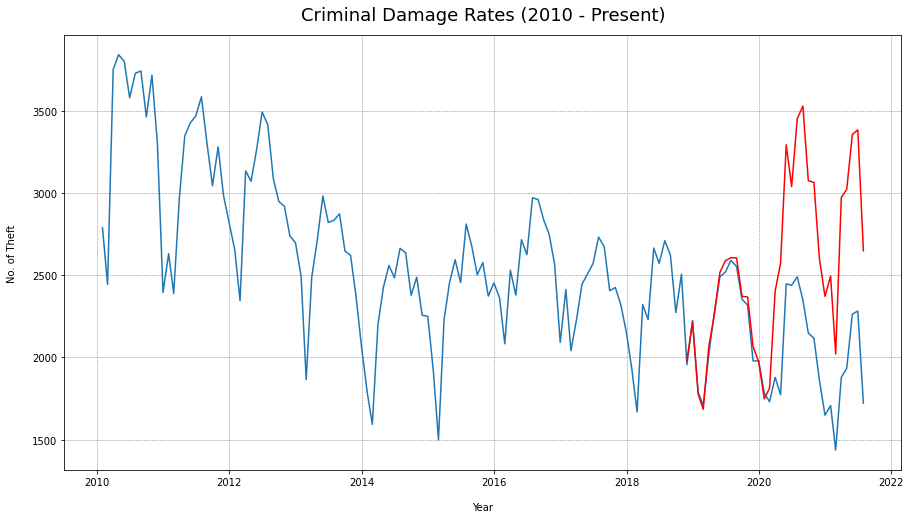

In [256]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='lr_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Ridge Regression

In [257]:
# Finding best ridge alpha
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(Z_train_pca, y_train)

print (optimal_ridge.alpha_)

25.52908068239518


In [258]:
# Instantiate ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Z_train_pca, y_train, cv=5)

print (f'Ridge training Cross Val Score: {np.mean(ridge_scores)}')

Ridge training Cross Val Score: 0.9781582725585334


In [259]:
# Fit model
ridge.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Ridge training score: {ridge.score(Z_train_pca, y_train)}')
print (f'Ridge test score: {ridge.score(Z_test_pca, y_test)}')

Ridge training score: 0.9983779915225162
Ridge test score: -0.5101041991215209


In [260]:
ridge.coef_

array([ 7.41604278e+01,  2.36479609e+01, -9.94981031e-01,  1.04302599e+01,
       -2.03684164e+00,  7.28568991e-01, -7.15529960e+00,  1.46439235e+00,
        1.60779216e+00,  4.82734468e+00,  1.53495948e+00,  1.73945228e+00,
        5.10820941e-01, -1.48042858e+00, -3.25975467e+00,  3.17357215e+00,
       -1.19479621e+00,  6.91520042e+00,  3.26788012e-01, -6.70904940e+00,
        1.41629115e+00, -1.27074638e+00, -3.03919758e+00,  3.97353504e+00,
       -5.61917571e-01,  1.41860715e+00,  5.34686880e-01, -1.61267624e+00,
        4.34149056e+00,  9.34441272e-01,  4.19075208e-01, -1.06256463e+00,
        1.73232126e+00, -6.34728420e+00,  3.42143894e-02,  7.43936428e+00,
        3.76333262e+00,  2.68159681e+00,  2.60466744e-01,  1.43393715e+00,
        1.01457958e+00,  2.66013485e+00, -4.82069382e-01, -1.27423677e+00,
       -4.01688522e+00, -3.62275156e+00, -1.89094106e-01, -6.14693604e+00,
       -1.02337398e+00, -7.56186149e+00,  3.89177542e+00, -5.79008124e-01,
        1.37448187e+00,  

In [261]:
# Finding ridge predictions
y_preds_r = ridge.predict(Z_test_pca)

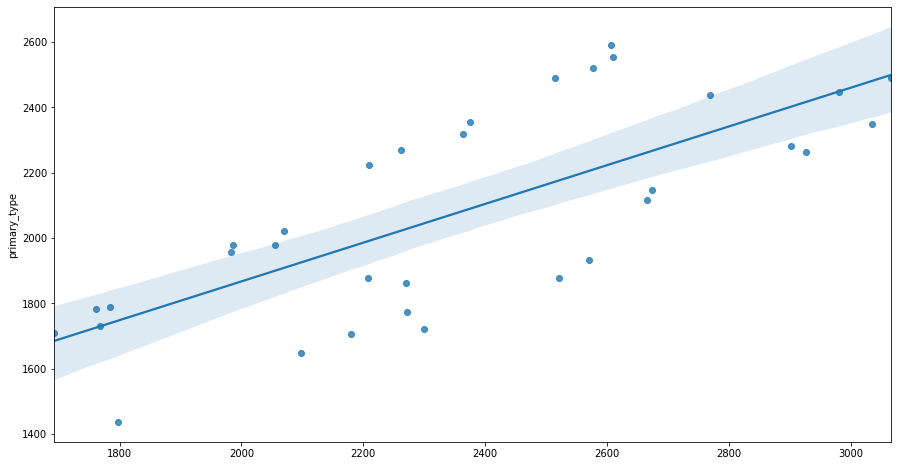

In [262]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_r, y_test);

In [263]:
# Evaluation
mse_ridge = mean_squared_error(y_test, y_preds_r)
print (f'MSE Score: {mse_ridge}')

rmse_ridge = mean_squared_error(y_test, y_preds_r, squared=False)
print (f'RMSE Score: {rmse_ridge}')

mape_ridge = mean_absolute_percentage_error(y_test, y_preds_r)
print (f'MAPE score: {mape_ridge}')

MSE Score: 146517.27612374368
RMSE Score: 382.77575174473066
MAPE score: 0.1407822106545885


In [264]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['ridge_predictions'] = pd.Series(y_preds_r)

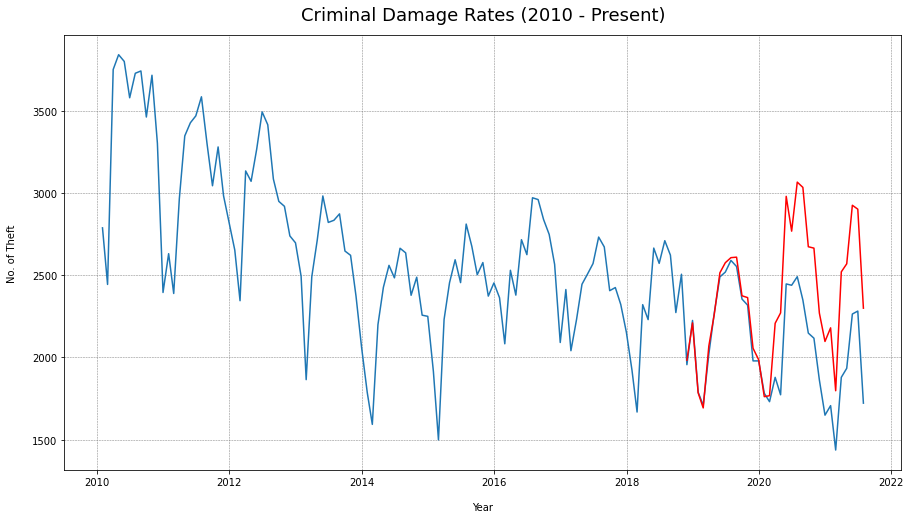

In [265]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='ridge_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Lasso Regression

In [266]:
# Finding best lasso alpha
optimal_lasso = LassoCV(n_alphas=20, cv=5, max_iter=10000)
optimal_lasso.fit(Z_train_pca, y_train)

print (optimal_lasso.alpha_)

3.227809294169191


In [267]:
# Instantiate Lasso regression
lasso = Lasso(alpha=optimal_lasso.alpha_, max_iter=10000)
lasso_scores = cross_val_score(lasso, Z_train_pca, y_train, cv=5)

print (f'Lasso training Cross Val Score: {np.mean(lasso_scores)}')

Lasso training Cross Val Score: 0.9817466610351998


In [268]:
# Fit model
lasso.fit(Z_train_pca, y_train)

# Scores for train and test data
print (f'Lasso training score: {lasso.score(Z_train_pca, y_train)}')
print (f'Lasso test score: {lasso.score(Z_test_pca, y_test)}')

Lasso training score: 0.997324286531183
Lasso test score: 0.9583176463016403


In [269]:
lasso.coef_

array([74.49082324, 23.85786241, -0.37054527, 10.24953018, -1.25498932,
        0.        , -6.66189852,  0.52038425,  0.59742555,  4.06524423,
        0.47604611,  0.68520429,  0.        , -0.32311145, -2.24695608,
        2.12110971, -0.        ,  6.20396746,  0.        , -5.90506968,
        0.        , -0.        , -1.70849769,  2.72345198, -0.        ,
        0.        ,  0.        , -0.        ,  2.93770769,  0.        ,
        0.        , -0.        ,  0.        , -5.0627773 ,  0.        ,
        6.23774943,  1.82061215,  0.50595556,  0.        ,  0.        ,
        0.        ,  0.14345826, -0.        , -0.        , -1.54497332,
       -0.99034752, -0.        , -4.10996472, -0.        , -5.76021871,
        0.96333067, -0.        ,  0.        ,  0.        , -0.99498414,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -2.43603109,  0.        , -1.29841902, -0.        ,  0.        ])

In [270]:
# Finding lasso predictions
y_preds_l = lasso.predict(Z_test_pca)

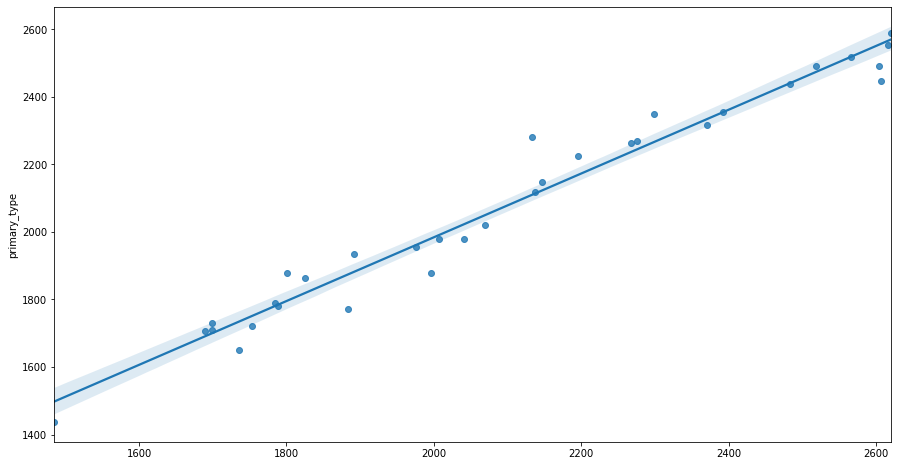

In [271]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_l, y_test);

In [272]:
# Evaluation
mse_lasso = mean_squared_error(y_test, y_preds_l)
print (f'MSE Score: {mse_lasso}')

rmse_lasso = mean_squared_error(y_test, y_preds_l, squared=False)
print (f'RMSE Score: {rmse_lasso}')

mape_lasso = mean_absolute_percentage_error(y_test, y_preds_l)
print (f'MAPE score: {mape_lasso}')

MSE Score: 4044.214253468657
RMSE Score: 63.594136942556716
MAPE score: 0.023687165451467217


In [273]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['lasso_predictions'] = pd.Series(y_preds_l)

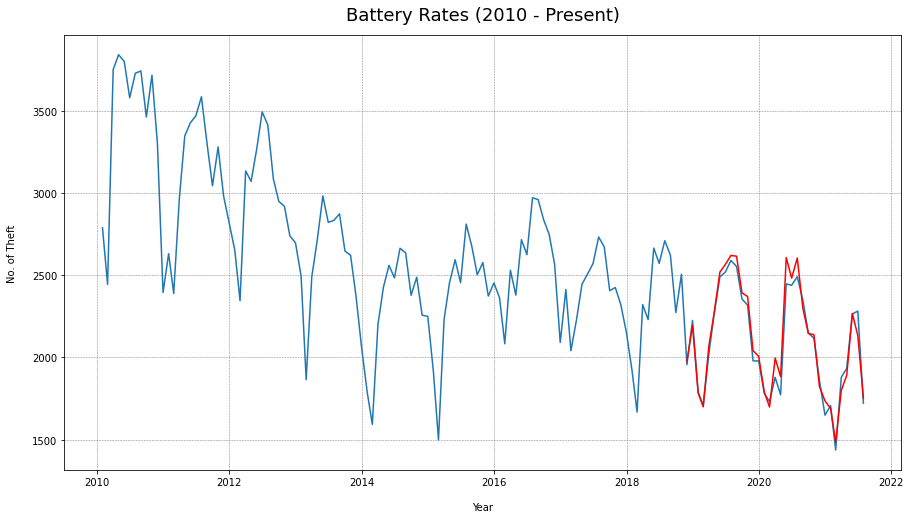

In [274]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='lasso_predictions', color='red')

plt.title('Battery Rates (2010 - Present)', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

## **Ensemble Methods**

### Random Forest

In [275]:
# Instantiate Random Forest Regression
rf = RandomForestRegressor()

# Fit model
rf.fit(Z_train, y_train)

RandomForestRegressor()

In [276]:
# Scores for train and test data
print (f'Random Forest training score: {rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {rf.score(Z_test, y_test)}')

Random Forest training score: 0.9976695106564868
Random Forest test score: 0.9429873968619135


In [277]:
rf_scores = cross_val_score(rf, Z_train, y_train, cv=5)

print (f'Random Forest training Cross Val Score: {np.mean(rf_scores)}')

Random Forest training Cross Val Score: 0.8819336797563022


In [278]:
# Finding lasso predictions
y_preds_rf = rf.predict(Z_test)

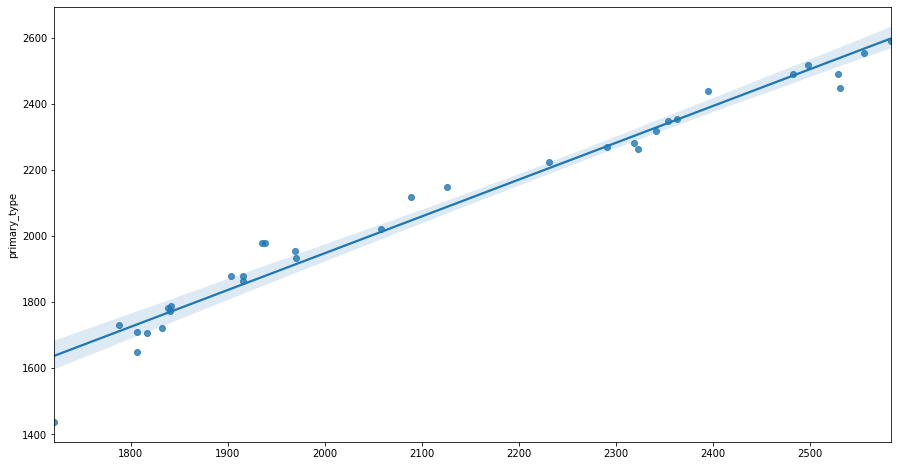

In [279]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf, y_test);

In [280]:
# Evaluation
mse_rf = mean_squared_error(y_test, y_preds_rf)
print (f'MSE Score: {mse_rf}')

rmse_rf = mean_squared_error(y_test, y_preds_rf, squared=False)
print (f'RMSE Score: {rmse_rf}')

mape_rf = mean_absolute_percentage_error(y_test, y_preds_rf)
print (f'MAPE score: {mape_rf}')

MSE Score: 5531.625778787881
RMSE Score: 74.37490019346501
MAPE score: 0.02831563436256933


In [281]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['rf_predictions'] = pd.Series(y_preds_rf)

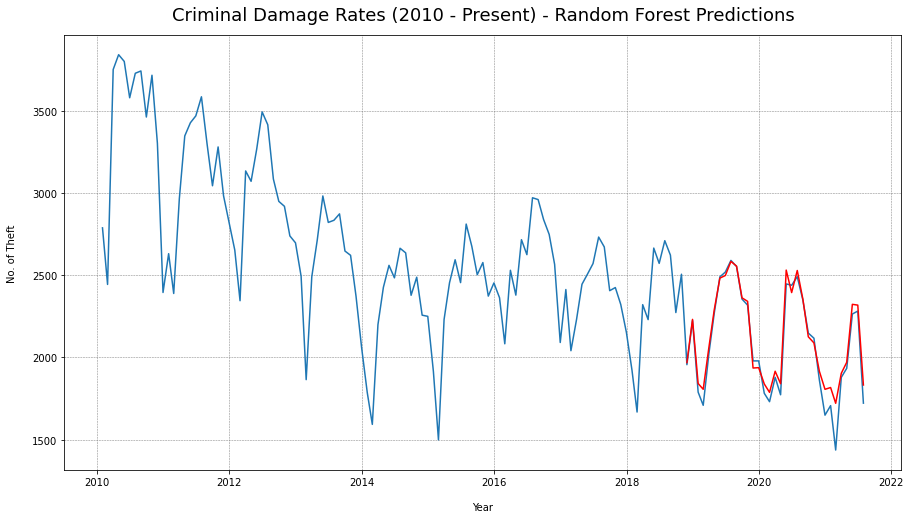

In [282]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='rf_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [283]:
# Instantiate Random Forest Regression
rf3 = RandomForestRegressor()

# Assign hyperparameters
rf_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [284]:
# Instatntiate GridsearchCV
gs_rf = GridSearchCV(rf3, param_grid=rf_params, cv=5, verbose=2)

# Fit model
gs_rf.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_rf.best_score_}')
print(f'Best parameters: {gs_rf.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=125; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_estimators=150; total time=   0.5s
[CV] END ...............min_samples_leaf=1, n_e

In [285]:
# Scores for train and test data
print (f'Random Forest training score: {gs_rf.score(Z_train, y_train)}')
print (f'Random Forest test score: {gs_rf.score(Z_test, y_test)}')

Random Forest training score: 0.9980744721387671
Random Forest test score: 0.951387526409996


In [286]:
y_preds_rf4 = gs_rf.predict(Z_test)

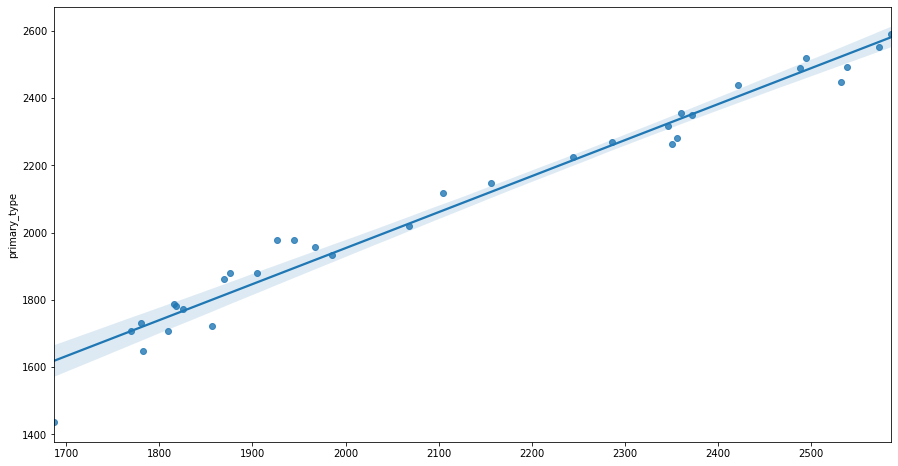

In [287]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_rf4, y_test);

In [288]:
# Evaluation
mse_rf4 = mean_squared_error(y_test, y_preds_rf4)
print (f'MSE Score: {mse_rf4}')

rmse_rf4 = mean_squared_error(y_test, y_preds_rf4, squared=False)
print (f'RMSE Score: {rmse_rf4}')

mape_rf4 = mean_absolute_percentage_error(y_test, y_preds_rf4)
print (f'MAPE score: {mape_rf4}')

MSE Score: 4716.606456818183
RMSE Score: 68.67755424313087
MAPE score: 0.025507440270157236


In [289]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['rf4_predictions'] = pd.Series(y_preds_rf4)

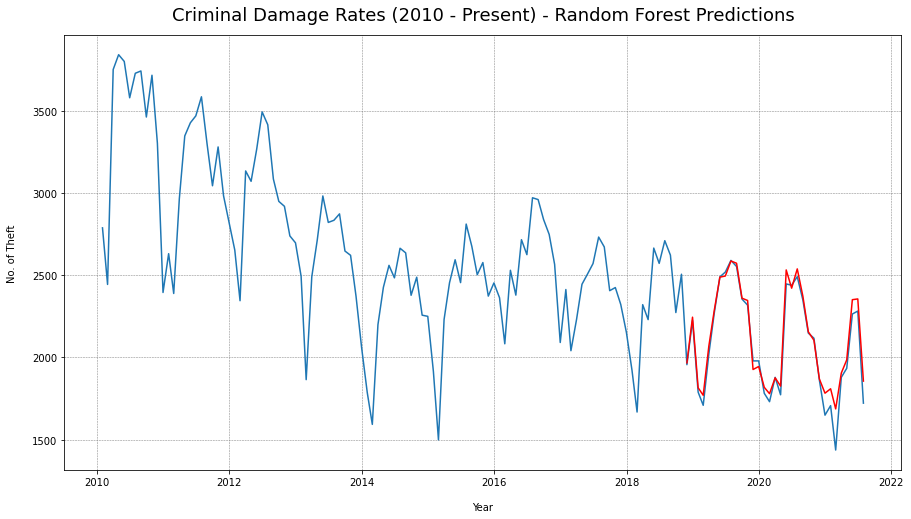

In [290]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='rf4_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - Random Forest Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### Gradient Boost

In [291]:
# Instantiate Random Forest Regression
gb = GradientBoostingRegressor()

# Fit model
gb.fit(Z_train, y_train)

GradientBoostingRegressor()

In [292]:
# Scores for train and test data
print (f'Gradient Boosting training score: {gb.score(Z_train, y_train)}')
print (f'Gradient Boosting test score: {gb.score(Z_test, y_test)}')

Gradient Boosting training score: 0.9999947159318155
Gradient Boosting test score: 0.9475245128341715


In [293]:
gb_scores = cross_val_score(gb, Z_train, y_train, cv=5)

print (f'Gradient Boosting training Cross Val Score: {np.mean(gb_scores)}')

Gradient Boosting training Cross Val Score: 0.912770914301832


In [294]:
# Finding lasso predictions
y_preds_gb = gb.predict(Z_test)

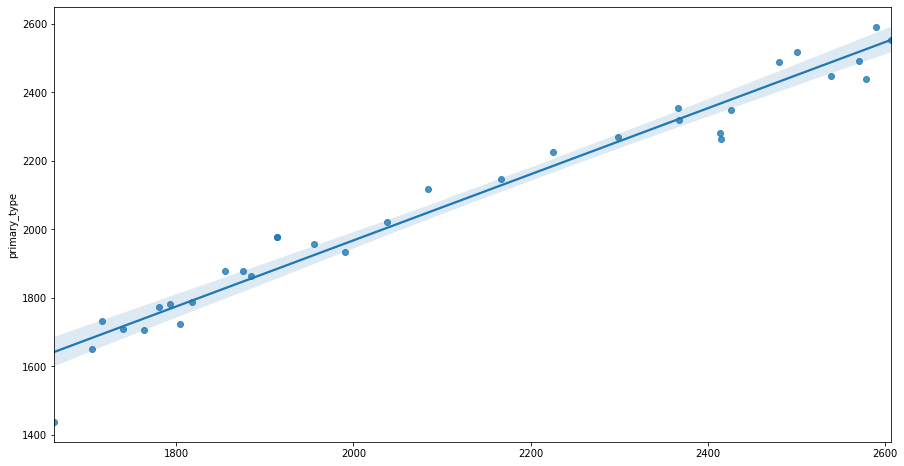

In [295]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb, y_test);

In [296]:
# Evaluation
mse_gb = mean_squared_error(y_test, y_preds_gb)
print (f'MSE Score: {mse_gb}')

rmse_gb = mean_squared_error(y_test, y_preds_gb, squared=False)
print (f'RMSE Score: {rmse_gb}')

mape_gb = mean_absolute_percentage_error(y_test, y_preds_gb)
print (f'MAPE score: {mape_gb}')

MSE Score: 5091.413855597759
RMSE Score: 71.3541439272994
MAPE score: 0.025360082075642575


In [297]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['gb_predictions'] = pd.Series(y_preds_gb)

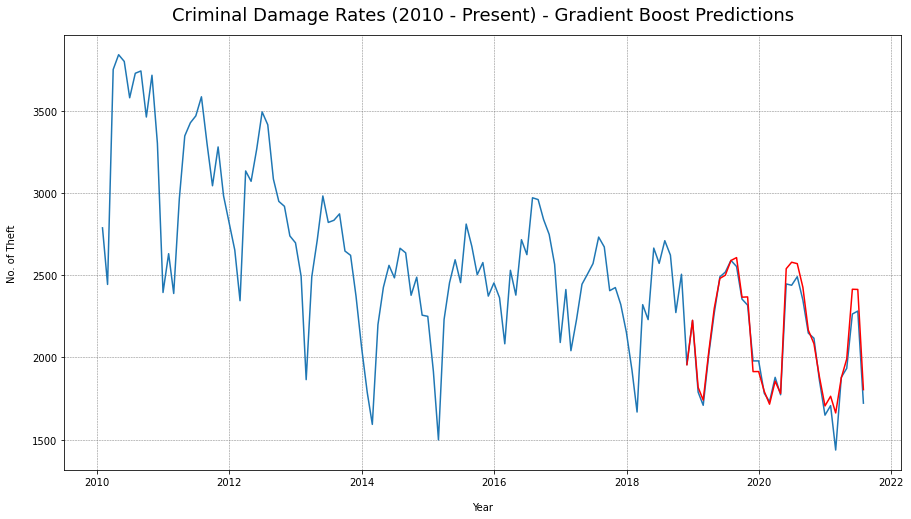

In [298]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='gb_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [299]:
# Instantiate Random Forest Regression
gb3 = GradientBoostingRegressor()

# Assign hyperparameters
gb_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'learning_rate': [.05, .1, .15, .2, .3]
}

In [300]:
# Instatntiate GridsearchCV
gs_gb = GridSearchCV(gb3, param_grid=gb_params, cv=5, verbose=2)

# Fit model
gs_gb.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_gb.best_score_}')
print(f'Best parameters: {gs_gb.best_params_}')

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=125; total time=   0.2s
[CV] END learning_rate=0.05, min_samples_leaf=1, n_estimators=150; total time

In [301]:
# Scores for train and test data
print (f'Gradient Boost training score: {gs_gb.score(Z_train, y_train)}')
print (f'Gradient Boost test score: {gs_gb.score(Z_test, y_test)}')

Random Forest training score: 0.9999997665600906
Random Forest test score: 0.9439918369798403


In [302]:
y_preds_gb4 = gs_gb.predict(Z_test)

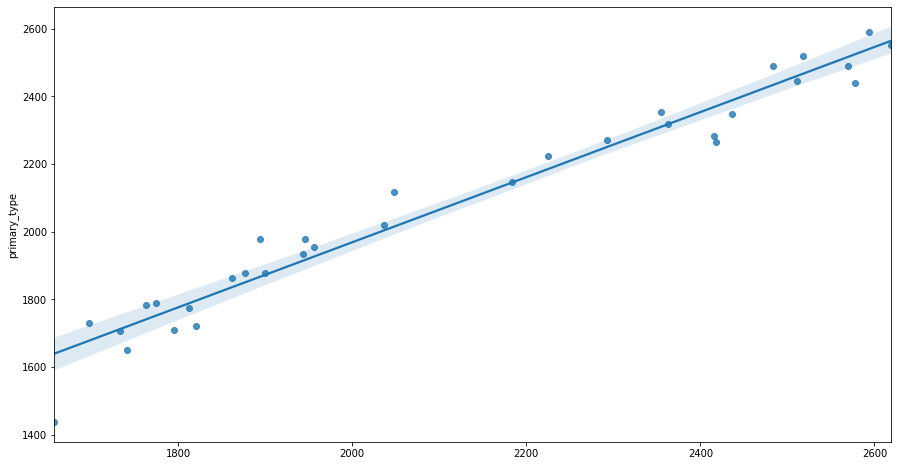

In [303]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_gb4, y_test);

In [304]:
# Evaluation
mse_gb4 = mean_squared_error(y_test, y_preds_gb4)
print (f'MSE Score: {mse_gb4}')

rmse_gb4 = mean_squared_error(y_test, y_preds_gb4, squared=False)
print (f'RMSE Score: {rmse_gb4}')

mape_gb4 = mean_absolute_percentage_error(y_test, y_preds_gb4)
print (f'MAPE score: {mape_gb4}')

MSE Score: 5434.170364655749
RMSE Score: 73.71682551938702
MAPE score: 0.026249050700017786


In [305]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['gb4_predictions'] = pd.Series(y_preds_gb4)

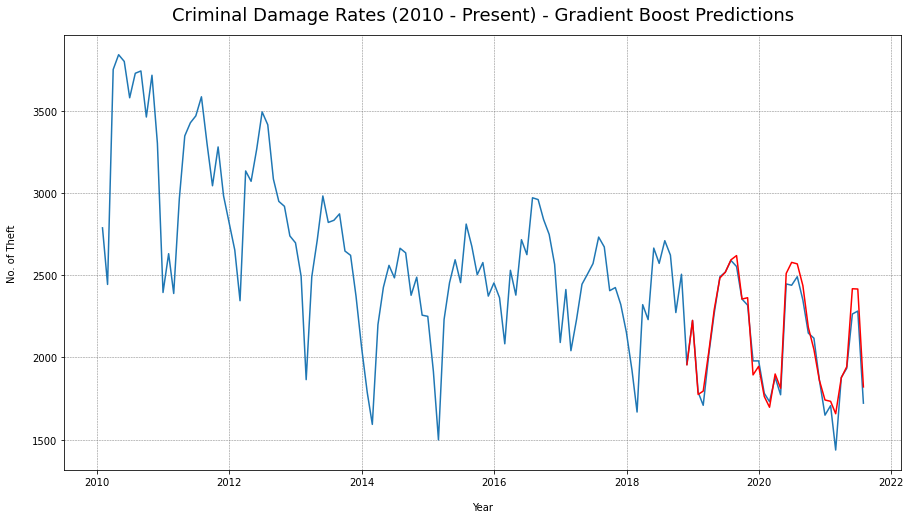

In [306]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='gb4_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - Gradient Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ADA Boost



In [307]:
# Instantiate Random Forest Regression
ab = AdaBoostRegressor()

# Fit model
ab.fit(Z_train, y_train)

AdaBoostRegressor()

In [308]:
# Scores for train and test data
print (f'ADA Boosting training score: {ab.score(Z_train, y_train)}')
print (f'ADA Boosting test score: {ab.score(Z_test, y_test)}')

ADA Boosting training score: 0.9934824603110184
ADA Boosting test score: 0.9357380592641724


In [309]:
ab_scores = cross_val_score(ab, Z_train, y_train, cv=5)

print (f'ADA Boosting training Cross Val Score: {np.mean(ab_scores)}')

ADA Boosting training Cross Val Score: 0.8801044645503968


In [310]:
# Finding lasso predictions
y_preds_ab = ab.predict(Z_test)

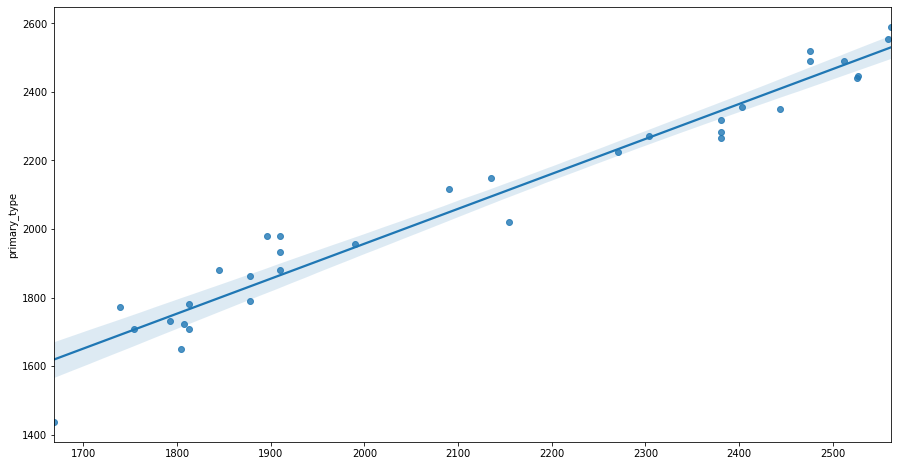

In [311]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab, y_test);

In [312]:
# Evaluation
mse_ab = mean_squared_error(y_test, y_preds_ab)
print (f'MSE Score: {mse_ab}')

rmse_ab = mean_squared_error(y_test, y_preds_ab, squared=False)
print (f'RMSE Score: {rmse_ab}')

mape_ab = mean_absolute_percentage_error(y_test, y_preds_ab)
print (f'MAPE score: {mape_ab}')

MSE Score: 6234.989956664056
RMSE Score: 78.96195258897829
MAPE score: 0.03272579803089874


In [313]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['ab_predictions'] = pd.Series(y_preds_ab)

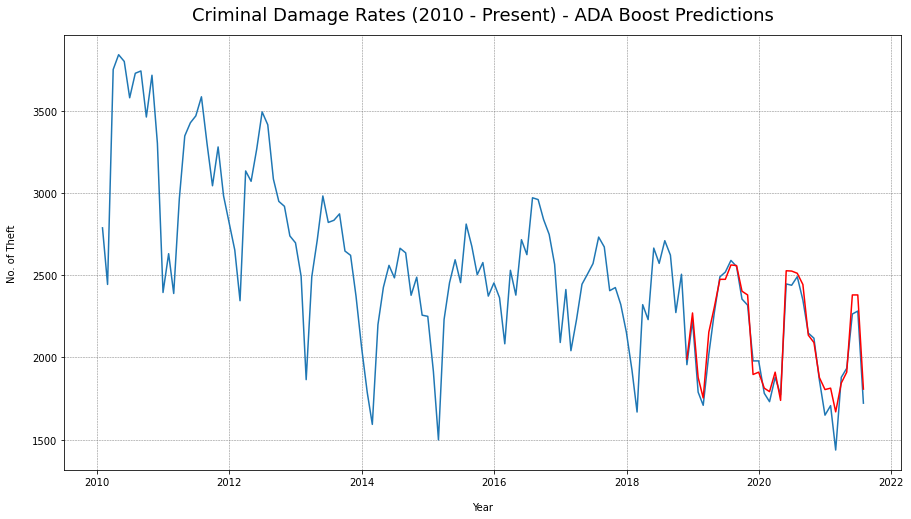

In [314]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='ab_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [315]:
# Instantiate Random Forest Regression
ab3 = AdaBoostRegressor()

# Assign hyperparameters
ab_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3]
}

In [316]:
# Instatntiate GridsearchCV
gs_ab = GridSearchCV(ab3, param_grid=ab_params, cv=5, verbose=2)

# Fit model
gs_ab.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_ab.best_score_}')
print(f'Best parameters: {gs_ab.best_params_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=125; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_estimators=150; total time=   0.4s
[CV] END ...............learning_rate=0.05, n_e

In [317]:
# Scores for train and test data
print (f'Random Forest training score: {gs_ab.score(Z_train, y_train)}')
print (f'Random Forest test score: {gs_ab.score(Z_test, y_test)}')

Random Forest training score: 0.993611420080675
Random Forest test score: 0.9539680301806379


In [318]:
y_preds_ab4 = gs_ab.predict(Z_test)

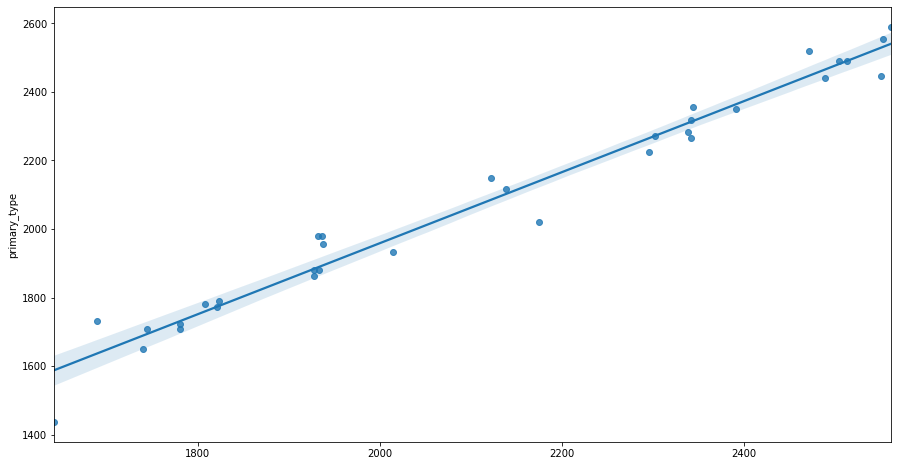

In [319]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_ab4, y_test);

In [320]:
# Evaluation
mse_ab4 = mean_squared_error(y_test, y_preds_ab4)
print (f'MSE Score: {mse_ab4}')

rmse_ab4 = mean_squared_error(y_test, y_preds_ab4, squared=False)
print (f'RMSE Score: {rmse_ab4}')

mape_ab4 = mean_absolute_percentage_error(y_test, y_preds_ab4)
print (f'MAPE score: {mape_ab4}')

MSE Score: 4466.234076076872
RMSE Score: 66.82988909220838
MAPE score: 0.02770634322849046


In [321]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['ab4_predictions'] = pd.Series(y_preds_ab4)

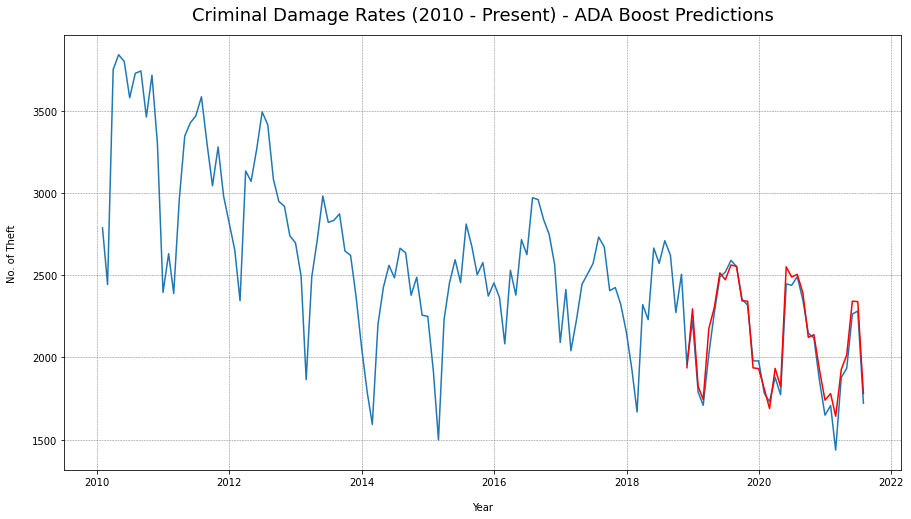

In [322]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='ab4_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - ADA Boost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### XGBoost

In [323]:
# Instantiate Random Forest Regression
xg = XGBRegressor()

# Fit model
xg.fit(Z_train, y_train)

[06:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [324]:
# Scores for train and test data
print (f'XG Boosting training score: {xg.score(Z_train, y_train)}')
print (f'XG Boosting test score: {xg.score(Z_test, y_test)}')

XG Boosting training score: 0.9999447129565197
XG Boosting test score: 0.9770823406705764


In [325]:
xg_scores = cross_val_score(xg, Z_train, y_train, cv=5)

print (f'XG Boosting training Cross Val Score: {np.mean(xg_scores)}')

[06:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boosting training Cross Val Score: 0.9424727512225948


In [326]:
# Finding lasso predictions
y_preds_xg = xg.predict(Z_test)

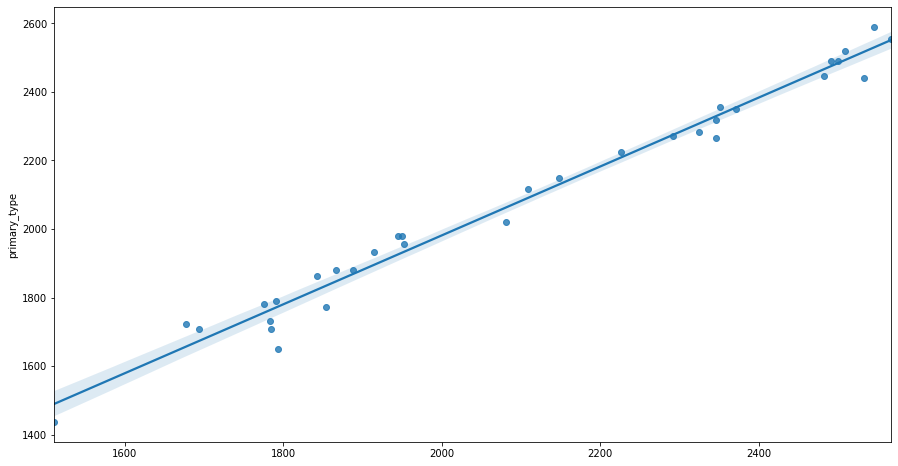

In [327]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg, y_test);

In [328]:
# Evaluation
mse_xg = mean_squared_error(y_test, y_preds_xg)
print (f'MSE Score: {mse_xg}')

rmse_xg = mean_squared_error(y_test, y_preds_xg, squared=False)
print (f'RMSE Score: {rmse_xg}')

mape_xg = mean_absolute_percentage_error(y_test, y_preds_xg)
print (f'MAPE score: {mape_xg}')

MSE Score: 2223.57703662596
RMSE Score: 47.15481986632925
MAPE score: 0.01727931397142612


In [329]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['xg_predictions'] = pd.Series(y_preds_xg)

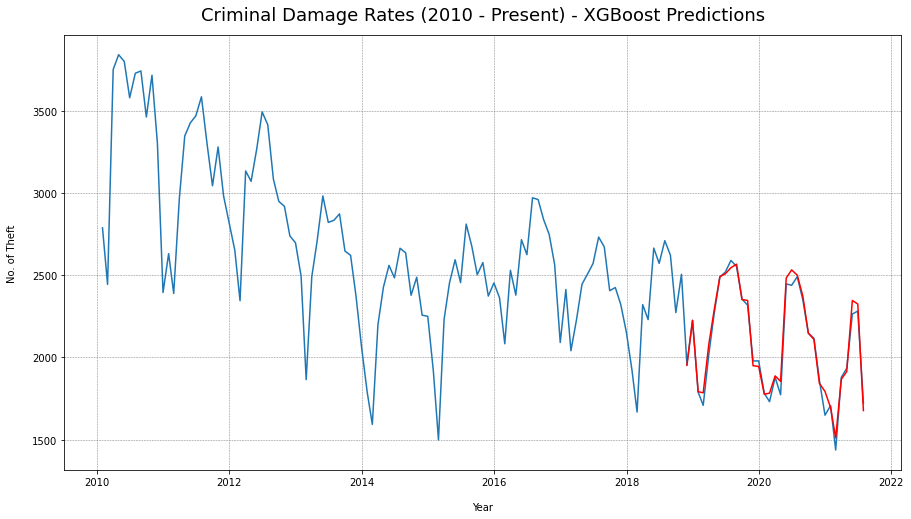

In [330]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='xg_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

**Gridsearch**

In [331]:
# Instantiate Random Forest Regression
xg3 = XGBRegressor()

# Assign hyperparameters
xg_params = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [.05, .1, .15, .2, .3],
    'lambda': [1, 2, 3]
}

In [332]:
# Instatntiate GridsearchCV
gs_xg = GridSearchCV(xg3, param_grid=xg_params, cv=5, verbose=2)

# Fit model
gs_xg.fit(Z_train, y_train)

# Best score and parameters
print(f'Best Gridserach score: {gs_xg.best_score_}')
print(f'Best parameters: {gs_xg.best_params_}')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[06:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .....lambda=1, learning_rate=0.05, n_estimators=100; total time=   0.1s
[06:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor 

In [333]:
# Scores for train and test data
print (f'XG Boost training score: {gs_xg.score(Z_train, y_train)}')
print (f'XG Boost test score: {gs_xg.score(Z_test, y_test)}')

XG Boost training score: 0.9999993939735918
XG Boost test score: 0.9775757351619483


In [334]:
y_preds_xg4 = gs_xg.predict(Z_test)

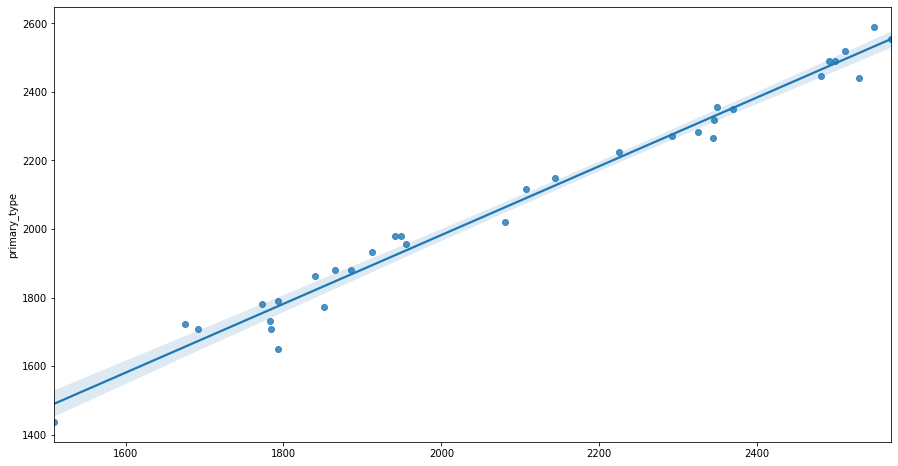

In [335]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(y_preds_xg4, y_test);

In [336]:
# Evaluation
mse_xg4 = mean_squared_error(y_test, y_preds_xg4)
print (f'MSE Score: {mse_xg4}')

rmse_xg4 = mean_squared_error(y_test, y_preds_xg4, squared=False)
print (f'RMSE Score: {rmse_xg4}')

mape_xg4 = mean_absolute_percentage_error(y_test, y_preds_xg4)
print (f'MAPE score: {mape_xg4}')

MSE Score: 2175.7056268435535
RMSE Score: 46.644459765802345
MAPE score: 0.017324809194114117


In [337]:
test_cridmg = test_cridmg.reset_index().drop('index', axis=1)
test_cridmg['xg4_predictions'] = pd.Series(y_preds_xg4)

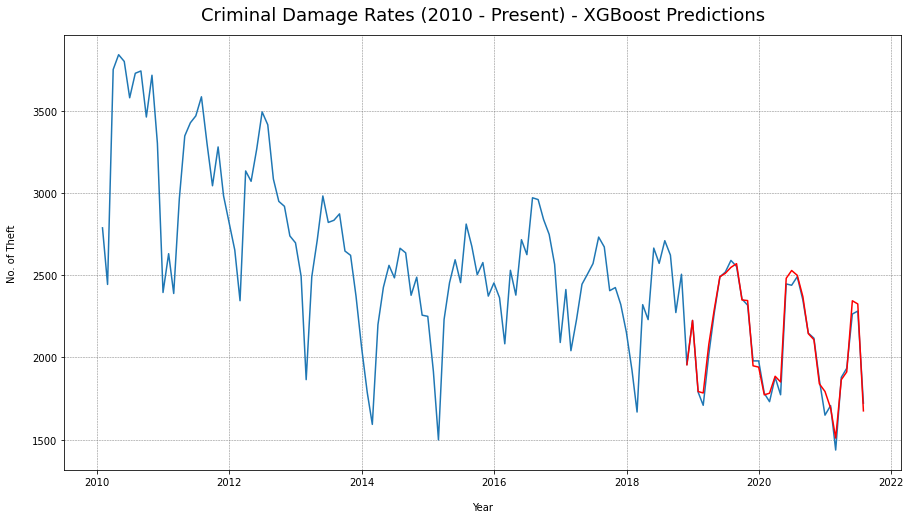

In [338]:
# Plot data
plt.figure(figsize=(15, 8))
sns.lineplot(data=cridmg, x='date', y='primary_type')
sns.lineplot(data=test_cridmg, x='date', y='xg4_predictions', color='red')

plt.title('Criminal Damage Rates (2010 - Present) - XGBoost Predictions', fontsize=18, y =1.02)
plt.xlabel('Year', labelpad=15)
plt.ylabel('No. of Theft', labelpad=15)
plt.grid(color='grey', linestyle='--', linewidth=0.5);

### ***Based on regression model:***

|Model|RMSE|MAE|
|---|---|---|
|Linear Regression|63.594136942556716|0.023687165451467217|
|Lasso Regression|63.594136942556716|0.023687165451467217|
|Ridge Regression|382.77575174473066|0.1407822106545885|
|Random Forest|68.67755424313087|0.025507440270157236|
|Gradient Boost|73.71682551938702|0.026249050700017786|
|Adaptive Boost|75.51970390099392|0.030802693552960843|
|XG Boost|46.644459765802345|0.017324809194114117|